In [119]:
import pandas as pd  
import numpy as np
from sys import argv
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
import os
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import string
import seaborn as sns
import FullCodeFunctions as myfun
# import scienceplots
import scipy
from networkx.drawing.nx_pydot import graphviz_layout  
from matplotlib import rcParams
# import distinctipy as dsp
import seaborn
from scipy.sparse import csgraph
from scipy.linalg import expm
# from palettable.colorbrewer.sequential import Purples_9, Oranges_9,Greys_9,Reds_9, Blues_9 ,RdPu_9
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# TESTING PURPOSES
from importlib import reload

reload(myfun)


# if after testing want to remove, change import FullCodeFunctions as myfun to from FullCodeFunctions import *
# and replace myfun. to "".


Importing libraries...


<module 'FullCodeFunctions' from '/media/marcuevas/#IZANA100/paper1/FullCodeFunctions.py'>

# 1. The data

**data_path**

Data must declare the functional relationships between plants and some species via a certain interaction type. Must contain the following columns:

- *plant_sp* the name of the plant species. (i.e. *Olea europaea var. sylvestris*)
- *animal_sp* the name of the interacting individual (i.e. *Larus michahellis*)
- *interaction_type* The functional interactional type between the two interacting species. (i.e. *seed dispersal*)
- *frequency_of_occurrence_weighted_by_sampling_effort* The strength of the interacion (i.e 0.516666667)

**abundance_path**

*optional* For each plant species informs of the number of individuals and the vegetal cover. Must contain the following columns:

- *plant_species* contains all the unique names of *plant_sp* of the data file.
- *Estimated_number_of_individuals*: int
- *species_cover (cm)*: float 

If *abundance_path* is not provided, each plant species *Estimated_number_of_individuals* is set to one.

In [120]:

'''data'''
data_path = 'data/NaRedona_observed_6layers_final.csv' 
abundance_path = 'data/NaRedona_observed_6layers_final_sinthetyc_abundance.cs' 


## TESTING DATA
data_path = 'data/data_test.csv'
abundance_path = None


head = 0 #header
sep=','


# wether to save or not the output plots
saving = False


The outputs are saved in the same folder as the input file. The following folder tree is created

```ascii
Results/
├── DataFrames/
└── Plots/
```

In [121]:
df_dir, plt_dir = myfun.creat_dir(data_path)

# 2. Resource-Function map

## 2. 1. Compute the entries of the Resource-Function map

The entries $P^\alpha_{i}$ (participation strength) of the Resource-Function map are obtained by aggregating the dataset at the level of plant sp and functions. 

The metadata set of {$f^\alpha_{ix}$} provides the probability of finding a specific resource $i$ and a specific animal/fungus species $x$ interacting via a specific function $\alpha$.

Entries are obteined by suitably integrating out consumers, using:

$$P^\alpha_{i} = 1 - \prod_{x} (1 - f^\alpha_{ix})$$ 

Where $P^\alpha_{i}$ is the probability of observing $i$ participating in $\alpha$.

Results are stored in Pandas DataFrame *df* with columns ['plant_sp', 'interaction_type', 'probability', 'abundance', 'cover'] or in matrix form *df_matrix*. Additionally, lists with the species and funcition names are stored.


In [122]:
RFmap = myfun.RFmap_prob(head, separator, data_path, df_dir, abundance_path = abundance_path)
RFmap_matrix, species, functions = myfun.RFmap_mat(RFmap, df_dir)
len_functions, len_species = len(functions), len(species)
display(RFmap)

Synthetic abundance file created in:  /home/marcuevas/Doctorado_Victor/fpi/primeros_datos/quinta_tarea/datos/data_test_sinthetyc_abundance.csv


plant_sp      interaction_type  probability  abundance  cover
0      Arisarum vulgare         decomposition          1.0          1    1.0
1      Arisarum vulgare  fungal pathogenicity          1.0          1    1.0
2      Arisarum vulgare       nutrient uptake          1.0          1    1.0
3    Asparagus horridus         decomposition          1.0          1    1.0
4    Asparagus horridus  fungal pathogenicity          1.0          1    1.0
..                  ...                   ...          ...        ...    ...
72  Withania frutescens  fungal pathogenicity          1.0          1    1.0
73  Withania frutescens             herbivory          1.0          1    1.0
74  Withania frutescens       nutrient uptake          1.0          1    1.0
75  Withania frutescens           pollination          1.0          1    1.0
76  Withania frutescens        seed dispersal          1.0          1    1.0

[77 rows x 5 columns]

In [123]:
# ecological functions acronyms are obtained using the first letter of each word 
dic_functions= myfun.dic_fun(functions)
# plant species acronyms are obtained using the first three letters of each word
dic_species= myfun.dic_sp(species,len_species)


## 2. 2. Resource-Function Network **P**

From the Resource-Function map, we derive the Resource-Function matrix **P**. **P** is interpreted as the weighted biadjacency matrix of a bipartite resource-functioin network. Nodes account for the sets of plant species and ecological functions, and links account how these are interwined ($P_i^\alpha$).

Results are stored in a dataframe (P_matrix_df) where each row account for a single plant sp, and each column to the participation strength with each ecological function.

For conviniency, results are also stored in the corresponding *numpy* 2d-array form and its transpose (P_matrix, P_matrix_t).

In [124]:
P_matrix_df, P_matrix, P_matrix_t = myfun.p_matrix(RFmap_matrix, functions)
display(P_matrix_df)

plant_sp  nutrient uptake  fungal pathogenicity  \
0             Withania frutescens              1.0                   1.0   
1                     Suaeda vera              1.0                   1.0   
2                Medicago arborea              1.0                   1.0   
3               Lavatera maritima              1.0                   1.0   
4            Euphorbia dendroides              1.0                   1.0   
5   Olea europaea var. sylvestris              1.0                   1.0   
6                  Geranium molle              1.0                   1.0   
7                 Fagonia cretica              1.0                   1.0   
8                Ephedra fragilis              1.0                   1.0   
9            Diplotaxis ibicensis              1.0                   1.0   
10              Narcissus tazetta              1.0                   1.0   
11                    Limonium sp              1.0                   1.0   
12                Heliotropium sp              1.0                   1.0   
13             Chenopodium murale              1.0                   1.0   
14             Asparagus horridus              1.0                   1.0   
15               Arisarum vulgare              1.0                   1.0   

    decomposition  pollination  seed dispersal  herbivory  
0             1.0          1.0             1.0        1.0  
1             1.0          1.0             1.0        1.0  
2             1.0          1.0             1.0        1.0  
3             1.0          1.0             1.0        1.0  
4             1.0          1.0             1.0        1.0  
5             1.0          0.0             1.0        1.0  
6             1.0          1.0             1.0        0.0  
7             1.0          1.0             1.0        0.0  
8             1.0          1.0             0.0        1.0  
9             1.0          1.0             0.0        1.0  
10            1.0          1.0             0.0        0.0  
11            1.0          0.0             1.0        0.0  
12            1.0          1.0             0.0        0.0  
13            1.0          1.0             0.0        0.0  
14            1.0          0.0             0.0        0.0  
15            1.0          0.0             0.0        0.0

## 2. 3. Visualization

Rows and columns are sorted to quickly display the nested structure of the network. Particularly both axis are sorted by computing the sum of their elements independently in descending order.

In [125]:
"""sort P"""

function_sorted = P_matrix_df.columns[1:].to_list()
species_sorted =  P_matrix_df['plant_sp'].to_list()

RFmap_matrix_s = myfun.sort_RFmap_matrix(RFmap_matrix, function_sorted, species_sorted)

In [126]:
# Some auxiliary variables for plotting

# Labels
labels_f = [dic_functions[ff] for ff in function_sorted]
labels_p = [dic_species[pp] for pp in species_sorted]

# Italic  plant labels
labels_p_ent = P_matrix_df["plant_sp"].to_list()
labels_p_it = []
for strg in labels_p_ent:
    words = strg.split(" ", 1)
    if len(words) >1:
        strg_it = r'%s $\mathit{%s}$' % (words[0].capitalize(), words[1:][0])
    else:
        strg_it = f'{words[0].capitalize()}'
    labels_p_it.append(strg_it)



### $P^t$

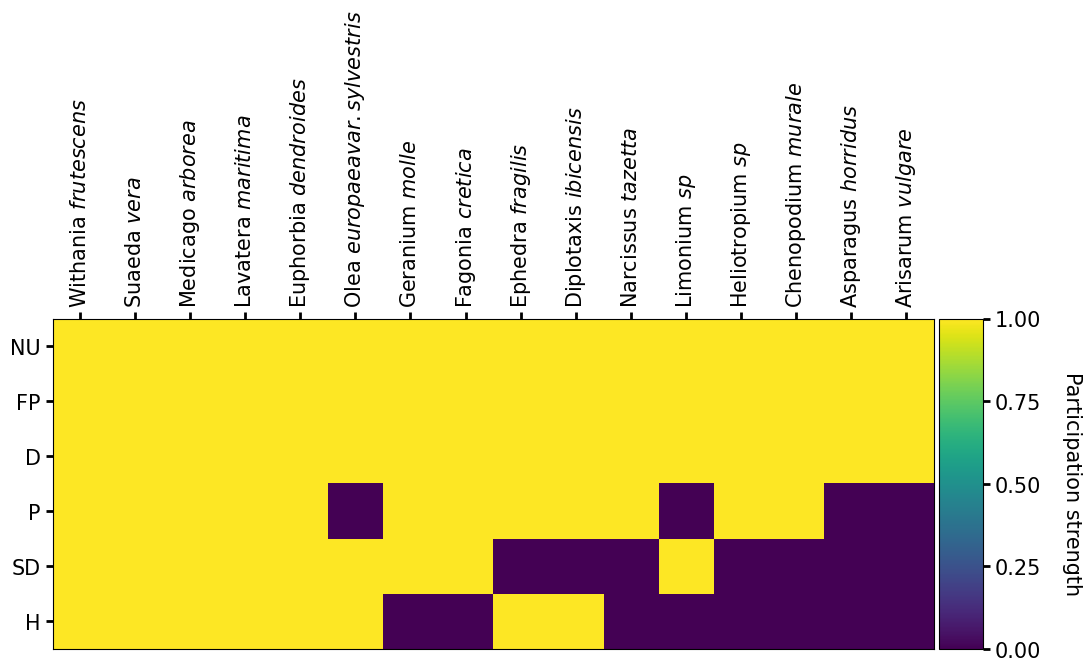

In [127]:
fontsize = 15

fig, ax = plt.subplots(figsize=(12,8), dpi=100)   
shw = ax.imshow(P_matrix_t, cmap = 'viridis', vmin= 0 , vmax=1)

ax.set_xticks(np.arange(np.shape(P_matrix)[0]), minor=False)
ax.set_xticklabels(labels_p_it, minor=False, fontsize=fontsize, rotation = 90)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(np.shape(P_matrix)[1]), minor=False)
ax.set_yticklabels(labels_f, minor=False, fontsize=fontsize)

#colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(shw, cax=cax, ticks= np.linspace(0, 1,5))
cb.ax.tick_params(labelsize=fontsize,width = 2, length = 5)
cb.set_label('Participation strength', labelpad=30,rotation=-90, fontsize = fontsize)

# ticks
for t in cb.ax.get_yticklabels():
     t.set_fontsize(fontsize)   
ax.tick_params(axis='both', which='major', labelsize=fontsize, width=2, length=5)


if saving:
     plt.savefig(plt_dir + '/P_t.pdf', bbox_inches='tight' ,  dpi=100 ) #save


# 3. Phyto- and Functio-centric embeddings

## 3. 1. Phyto-centric embedding 

By projecting the map into the function class, a function-function effective interaction network is derive using:
$$\Phi = P^\intercal P$$

Nodes in $\Phi$ correspond to ecological functions, and links (with weight $\Phi ^{\alpha\beta} = \sum_i P_i^\alpha P_i^\beta$) leverage how species connect functions.

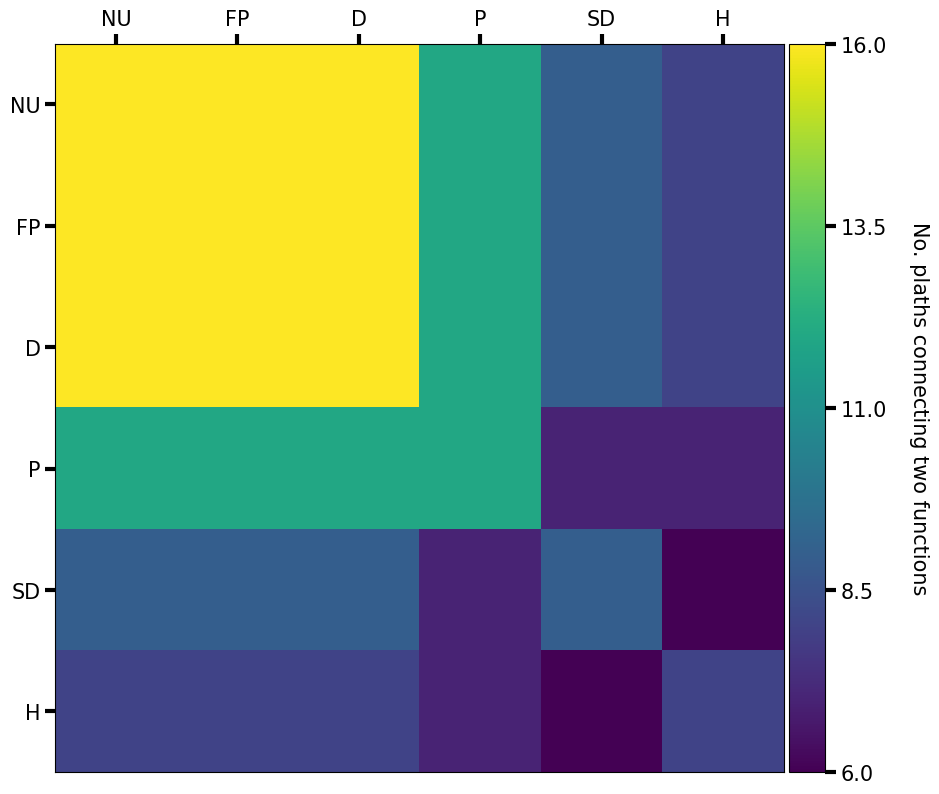

In [128]:


P_t_times_P = np.matmul(P_matrix_t, P_matrix) 
v_min = np.floor(P_t_times_P.min())
v_max = np.ceil(P_t_times_P.max())

fig, ax = plt.subplots(figsize=(12,8), dpi=100)   
shw = ax.imshow(P_t_times_P, cmap = 'viridis', vmin=v_min , vmax=v_max)

#colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(shw, cax=cax, ticks= np.linspace(v_min, v_max, 5))

cb.ax.tick_params(labelsize=fontsize,
                  width = 3, 
                  length = 8)
cb.set_label('No. plaths connecting two functions', 
             labelpad=30,
             rotation=-90, 
             fontsize = fontsize)

#ticks
for t in cb.ax.get_yticklabels():
     t.set_fontsize(fontsize)    
# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(np.shape(P_matrix)[1]), minor=False)
ax.set_xticks(np.arange(np.shape(P_matrix)[1]), minor=False)
ax.xaxis.tick_top()
ax.set_yticklabels(labels_f, minor=False, fontsize=fontsize);
ax.set_xticklabels(labels_f, minor=False, fontsize=fontsize);

fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=fontsize, width=3, length=7)


if saving:
     plt.savefig(plt_dir + '/P_t_times_P.pdf', bbox_inches='tight',  dpi=100  ) #save


## 3. 2. Functio-centric embedding 

By projecting the map into the plant class, a plant-plant effective interaction network is derive using:
$$\Pi = PP^\intercal$$

Nodes in $\Pi$ correspond to plant species, and links (with weight $\Pi _{ij} = \sum_\alpha P_i^\alpha P_j^\alpha$) leverage how function connect plant resources.

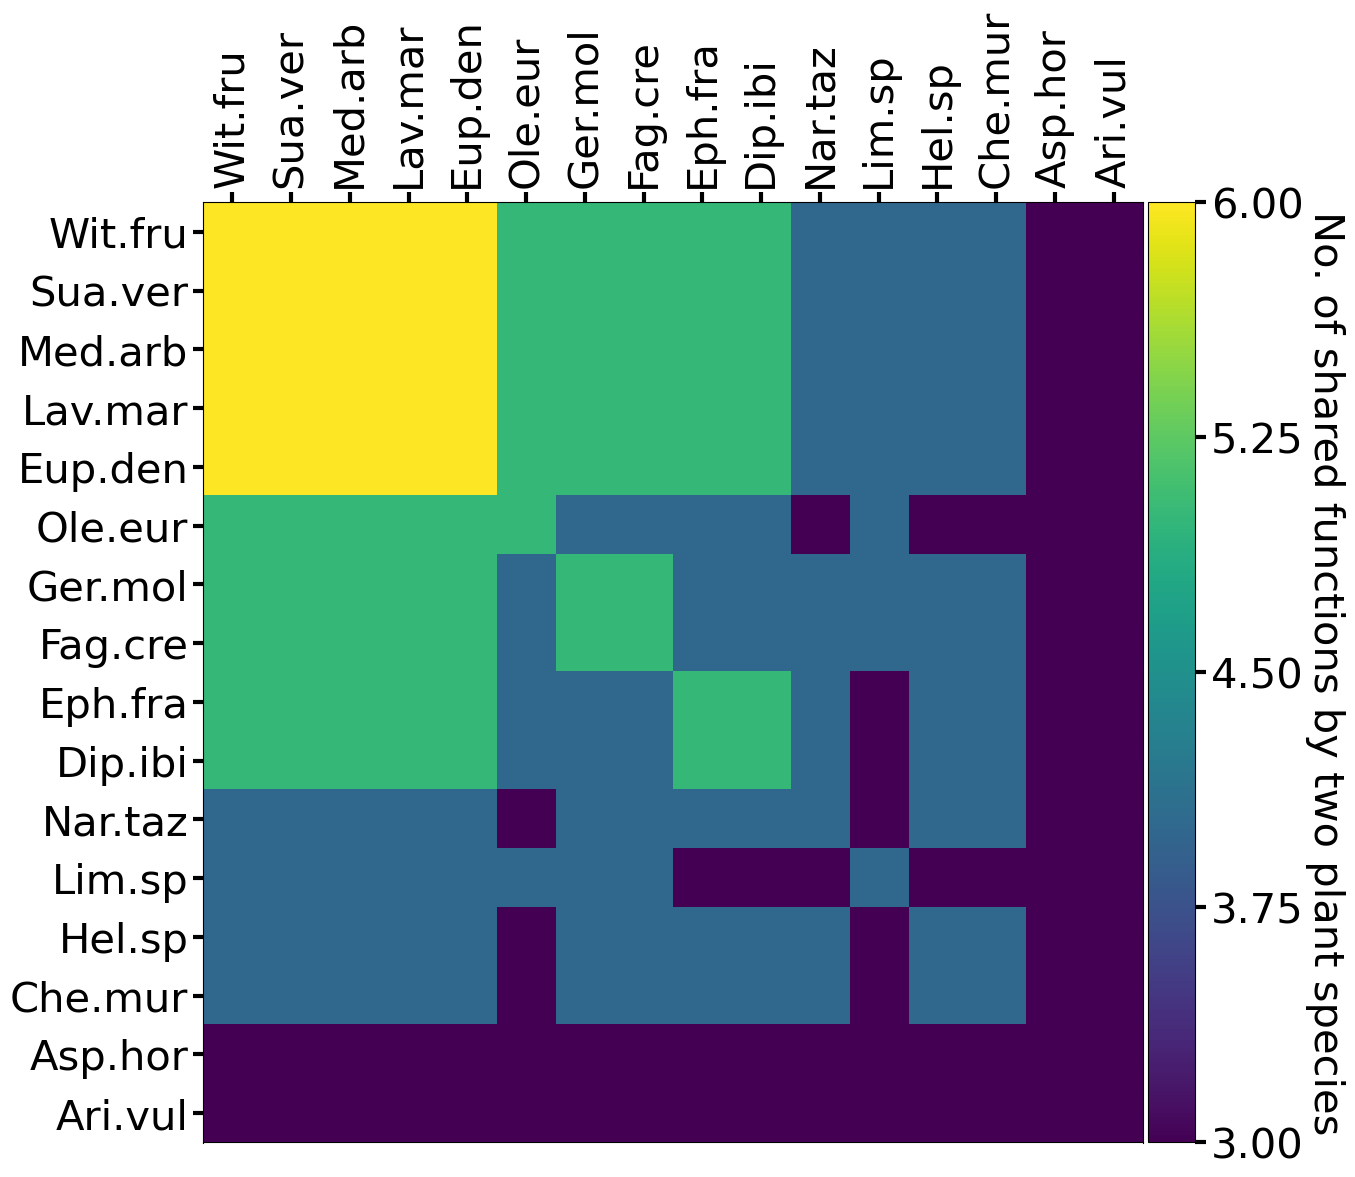

In [129]:
fontsize = 30
P_times_P_t = np.matmul(P_matrix, P_matrix_t)
# v_min and v_max 
v_min = np.floor(P_times_P_t.min())
v_max = np.ceil(P_times_P_t.max())

fig, ax = plt.subplots(figsize=(12,12), dpi=100)   
shw = ax.imshow(P_times_P_t, cmap = 'viridis', vmin=v_min , vmax=v_max)

#colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(shw, cax=cax,ticks= np.linspace(v_min, v_max,5))
cb.ax.tick_params(labelsize=fontsize,
                  width = 3, 
                  length = 8)
cb.set_label('No. of shared functions by two plant species', 
             labelpad=30,
             rotation=-90, 
             fontsize = fontsize)
#ticks
for t in cb.ax.get_yticklabels():
     t.set_fontsize(fontsize)
# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(np.shape(P_matrix)[0]), minor=False)
ax.set_xticks(np.arange(np.shape(P_matrix)[0]), minor=False)
ax.xaxis.tick_top()
fig.tight_layout()
ax.set_yticklabels(labels_p, minor=False, fontsize=fontsize);
ax.set_xticklabels(labels_p, minor=False,rotation =90, fontsize=fontsize);
ax.tick_params(axis='both', which='major', labelsize=fontsize, width=3, length=7)

if saving:
     plt.savefig(plt_dir + '/P_times_P_t.pdf', bbox_inches='tight',  dpi=100  ) #save


# 4. Network visualization

In this section, all plots showing networks that appear in the main manuscript and the Supplementary Information are generated.

Matrices $P$, $\Phi$ and $\Pi$ (and their disaggregates) serve as adjacency matrices of our ecological networks.

In [130]:
"""cell needed to solve a Networkx bug"""

class SelfLoop():
    def __init__(self, v_scale=0.25, h_scale=0.25, nodesize=300):
        self.v_scale = v_scale
        self.h_scale = h_scale
        self.nodesize = nodesize

    def selfloopstyle(self, posA, posB, *args, **kwargs):
        from matplotlib.path import Path

        selfloop_ht = 0.005 * self.nodesize

        data_loc = ax.transData.inverted().transform(posA)
        v_shift = self.v_scale * selfloop_ht
        #h_shift = v_shift * self.h_scale
        h_shift = self.h_scale * selfloop_ht
        path = [
            data_loc + np.asarray([0, v_shift]),
            data_loc + np.asarray([h_shift, v_shift]),
            data_loc + np.asarray([h_shift, 0]),
            data_loc,
            data_loc + np.asarray([-h_shift, 0]),
            data_loc + np.asarray([-h_shift, v_shift]),
            data_loc + np.asarray([0, v_shift]),
        ]

        ret = Path(ax.transData.transform(path), [1, 4, 4, 4, 4, 4, 4])

        return ret
   
    def style(self):
        return self.selfloopstyle


## 4. 1. Bipartite network

**P** is interpreted as the adjacency matrix of the bipartite plat species-function network, that links how species participates in ecological functions and the other way around.

In [131]:
G = nx.Graph()
G.add_nodes_from(labels_p)
G.add_nodes_from(labels_f)

for i, fs in enumerate(labels_f):
    for j, ps in enumerate(labels_p):
        G.add_edge(fs, ps, weight=P_matrix[j][i])

# compute the degree of the nodes of each partition
degree_sp = np.array([G.degree(weight='weight')[node] for node in labels_p])
degree_sp = degree_sp / np.sum(np.array([G.degree(weight='weight')[node] for node in labels_p]) )
degree_fn = np.array([G.degree(weight='weight')[node] for node in labels_f])
degree_fn = degree_fn / np.sum(np.array([G.degree(weight='weight')[node] for node in labels_f]) )


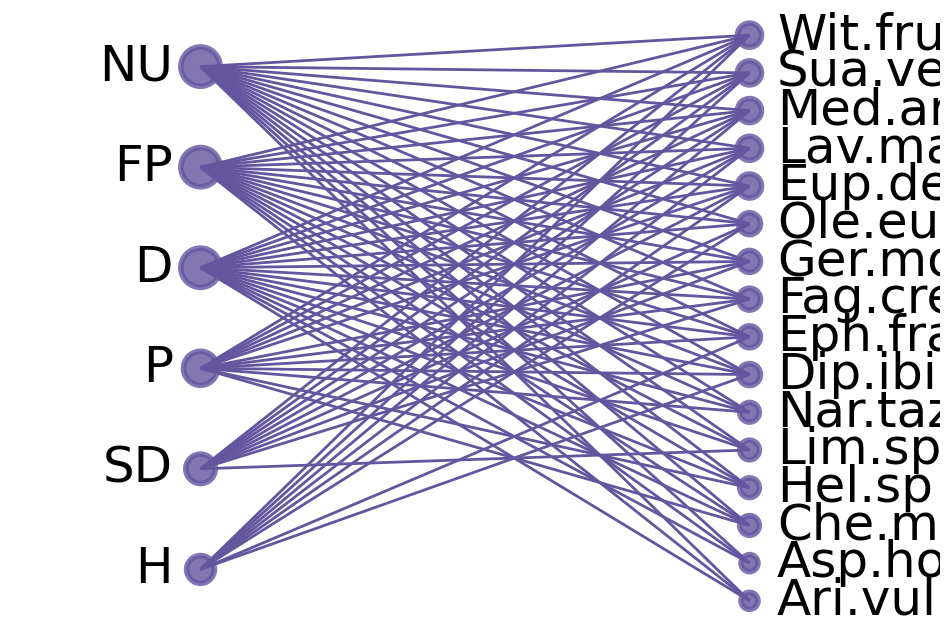

In [132]:
pos, pos_labels = myfun.bipartite_pos(labels_f, labels_p)

fig, ax = plt.subplots(figsize=(12,8), dpi=100)    
width =np.array([d["weight"] for u,v,d in G.edges(data=True)])
e = nx.draw_networkx_edges(G, pos=pos, edge_color = np.array([(100/256,85/256,160/256,1.0)]), width=(width)*2, ax=ax)
node_size  = np.array([G.degree(weight='weight')[node] for node in G.nodes])*50
nx.draw_networkx_nodes(G, pos=pos, node_size=node_size,node_color=np.array([(100/256,85/256,160/256,1.0)]), node_shape="o", alpha=0.8, linewidths=4, ax=ax)
nx.draw_networkx_labels(G, pos={k: item for k,item in pos_labels.items() if k in labels_p}, labels={label:label for label in labels_p} , ax=ax, font_size=fontsize*1.2, horizontalalignment = "left")  
nx.draw_networkx_labels(G, pos={k: item for k,item in pos_labels.items() if k in labels_f}, labels={label:label for label in labels_f} , ax=ax, font_size=fontsize*1.2, horizontalalignment = "right")  
plt.axis('off')
xlim = np.array(list(ax.get_xlim()))*1.4 #make plot lims wider in the x direction not to crop nodes
ylim = np.array(list(ax.get_ylim()))*0.9 #same in y direction
ax.set_xlim(xlim);
ax.set_ylim(ylim);

if saving:
    plt.savefig(plt_dir + '/plant_function_netwotks.pdf', bbox_inches='tight', dpi=100)
    plt.savefig(plt_dir + '/plant_function_netwotks.png', bbox_inches='tight', dpi=100)



## 4. 2.  Function-Function network

$\Phi$ serves as the adjacency matrix of the function-function effective interaction network. Nodes represent the ecological functions and edges are based on the number of plant species that simultaneously participates in a given pair of functions. 

In [133]:
G_T = nx.from_numpy_array(P_t_times_P, parallel_edges=False, create_using=None)  
G_T = nx.relabel_nodes(G_T, {np.array(G_T.nodes)[i]: labels_f[i] for i in range(len(G_T.nodes))} , copy=False)
pos = myfun.layer_layout(G_T, layout='shell')
dic_labels = {}
coord_scale = 1.35
for elem in pos:
    dic_labels[elem] = pos[elem] * coord_scale


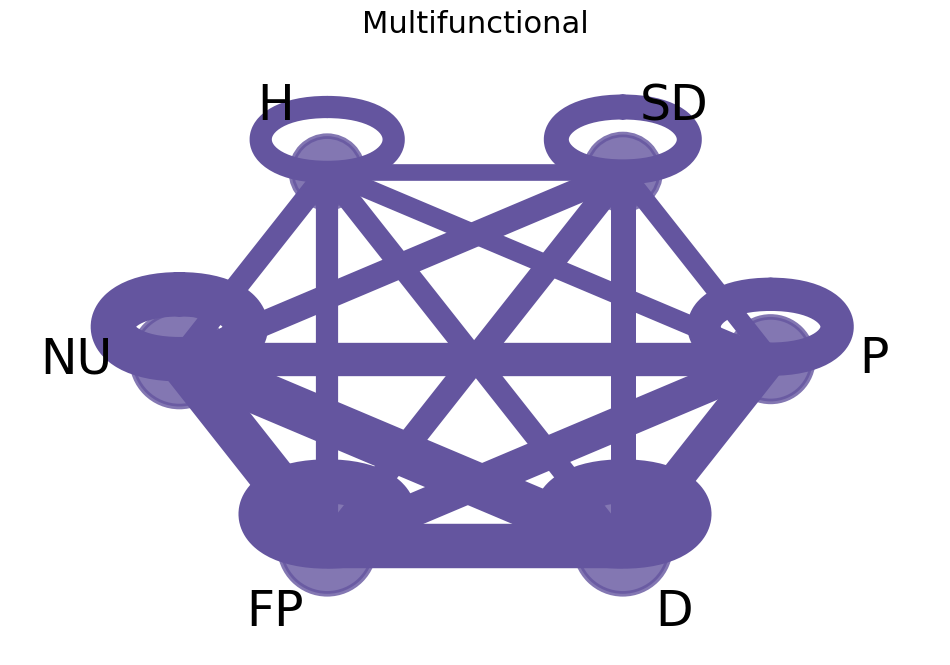

In [134]:
loop_size_x = .2
loop_size_y = .2
size_label =25
fontsize=22

fig, ax = plt.subplots(figsize=(12,8), dpi=100)   

# Edges 
width =np.array([d["weight"] for u,v,d in G_T.edges(data=True)])
e = nx.draw_networkx_edges(G_T, 
                           pos=pos, 
                           edge_color = np.array([(100/256,85/256,160/256,1.0)]), 
                           width=(width)*2, 
                           ax=ax,
                           )
for self_loop_fap in ax.patches:
    self_loop_fap._connector = SelfLoop(loop_size_x,loop_size_y).style()
ax.autoscale_view()

# Nodes
node_size  = np.array([G_T.degree(weight='weight')[node] for node in G_T.nodes])*50
nx.draw_networkx_nodes(G_T, 
                       pos=pos, 
                       node_size=node_size,
                       node_color=np.array([(100/256,85/256,160/256,1.0)]), 
                       node_shape="o", 
                       alpha=0.8,
                       linewidths=4, 
                       ax=ax,
                       )

# Labels
nx.draw_networkx_labels(G_T, 
                        pos=dic_labels, 
                        ax=ax, 
                        font_size=fontsize*1.6,
                        )  
plt.axis('off')
ax.set_title('Multifunctional',{'fontsize':fontsize}, pad=-20)
xlim = np.array(list(ax.get_xlim()))*1.3 #make plot lims wider in the x direction not to crop nodes
ylim = np.array(list(ax.get_ylim()))*1.3 #same in y direction
ax.set_xlim(xlim);
ax.set_ylim(ylim);

The specific role of species $i$ as a connector of functions can be disentangled from $\Phi$ by conditioning $\Phi$ only to a particular species $i$. This generates a collection of networks $\Phi|_i$, where 

- Each node $\alpha$ represents a different function and has a node weight $P_i ^\alpha$. This is used as the node size.
- A link between two functions $\alpha$ and $\beta$ means that the species $i$ participates in both functions simultaneously and the link weight $\Phi|_i ^{\alpha\beta} := P_i ^\alpha P_i ^\beta$ quantifies that contribution. This is captured by the edge width.

Node and edges colors are given by the node and multifunction participation indices (see Section 5).


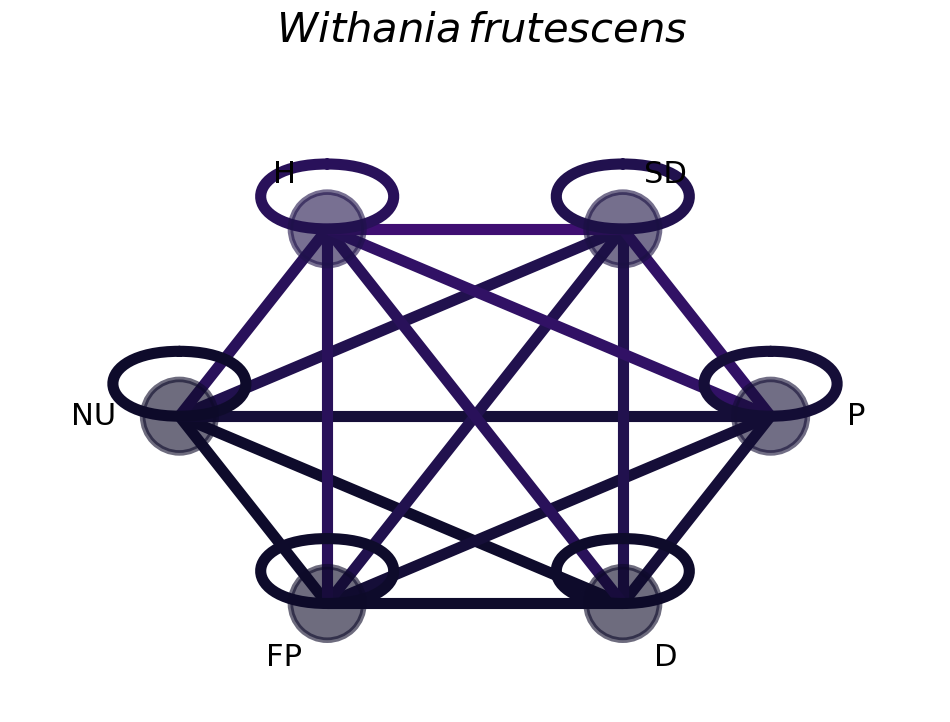

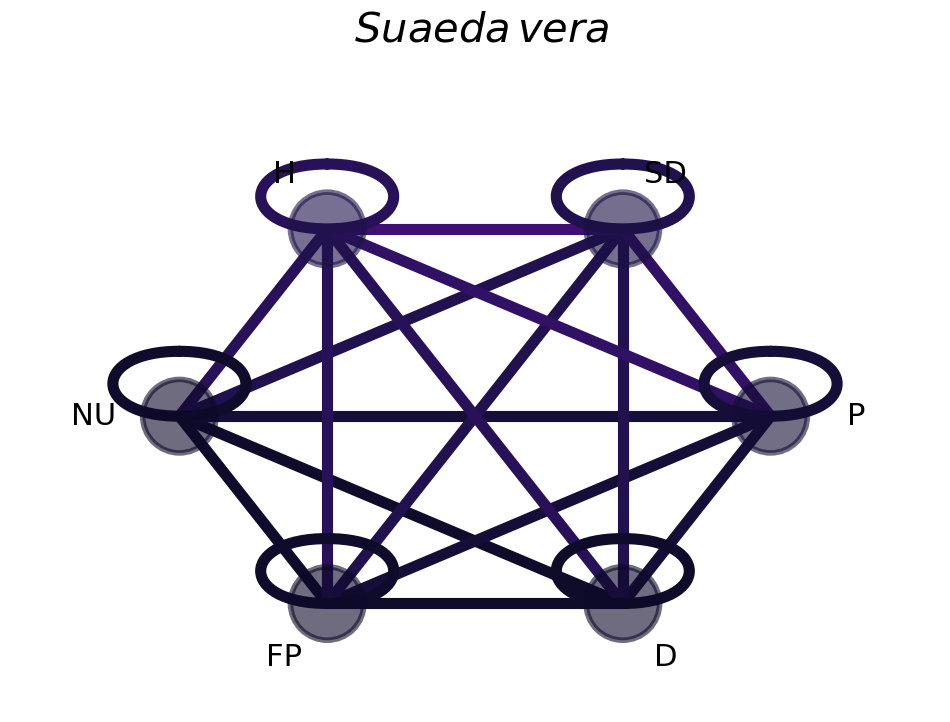

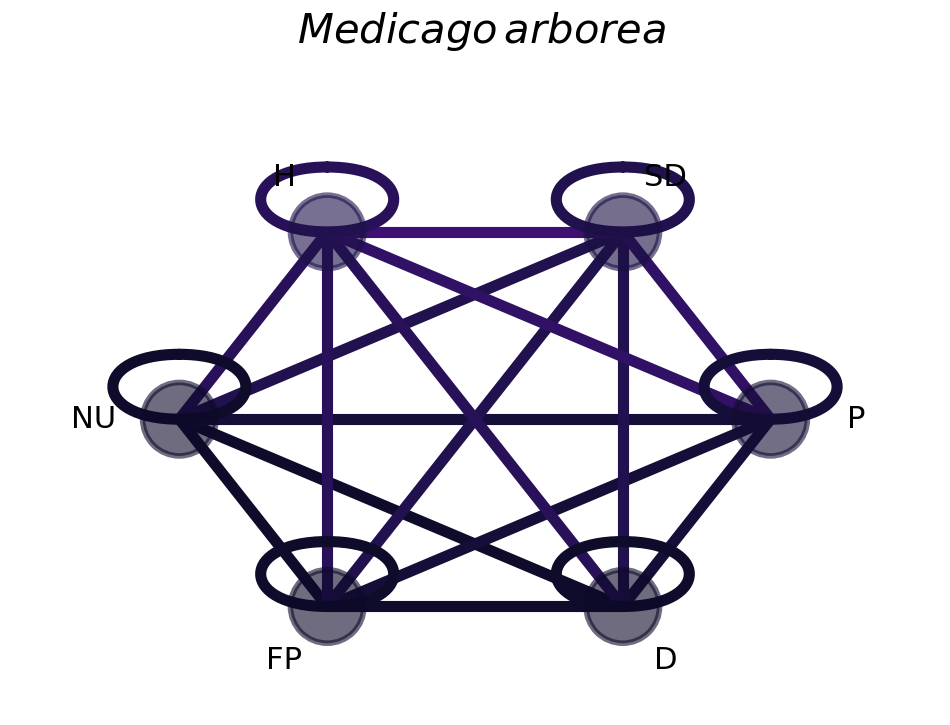

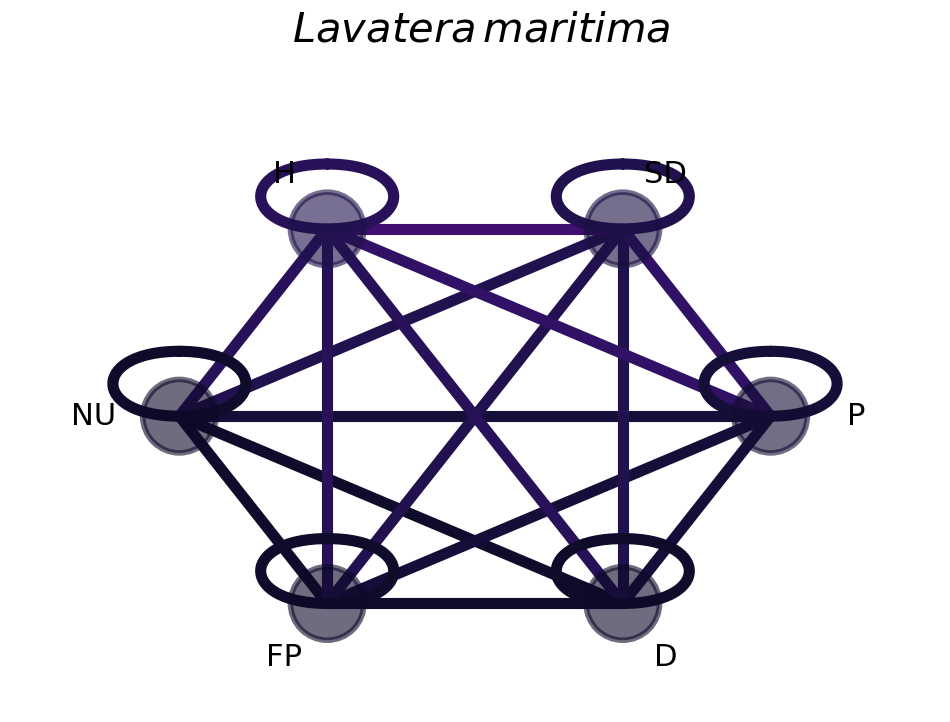

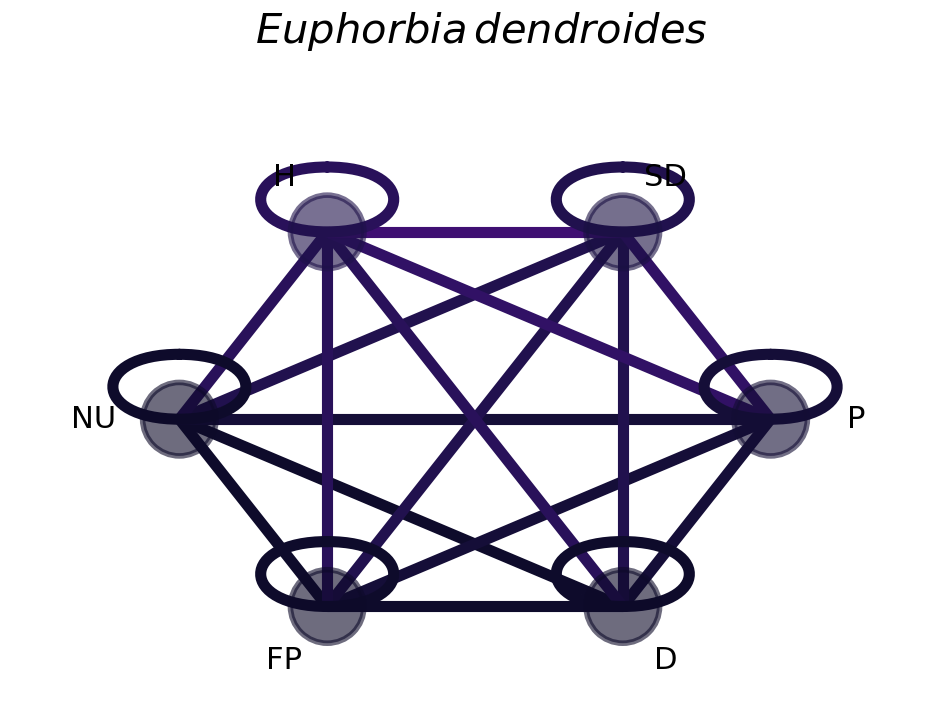

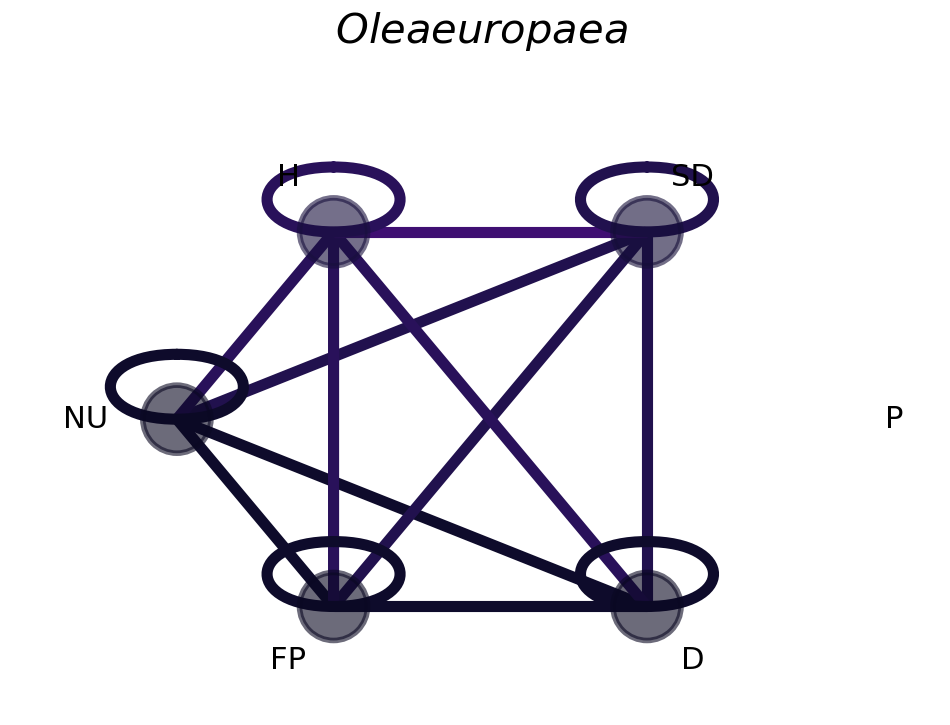

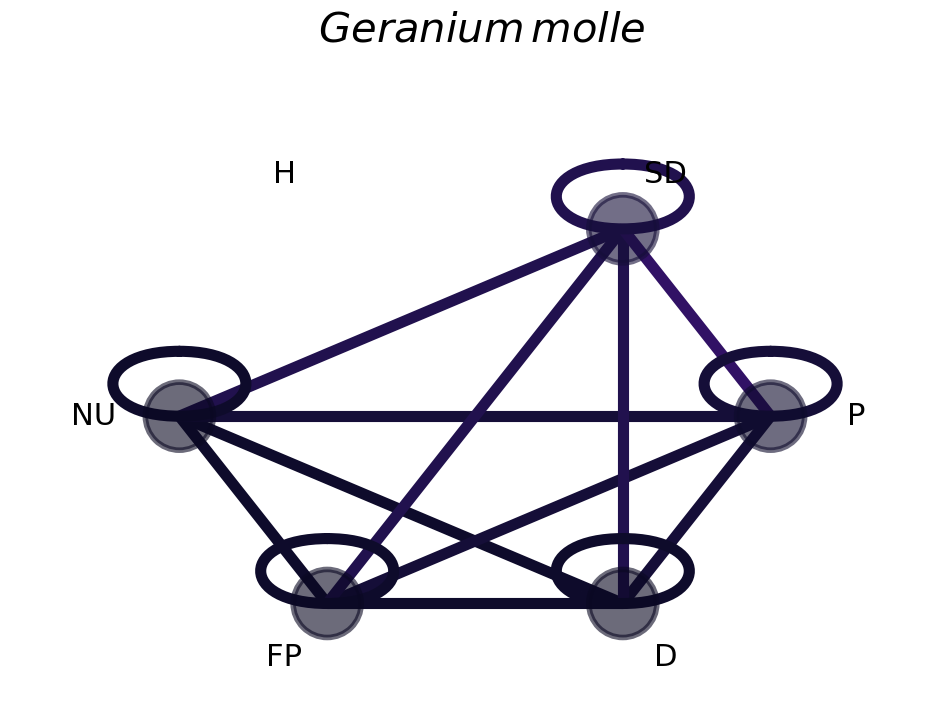

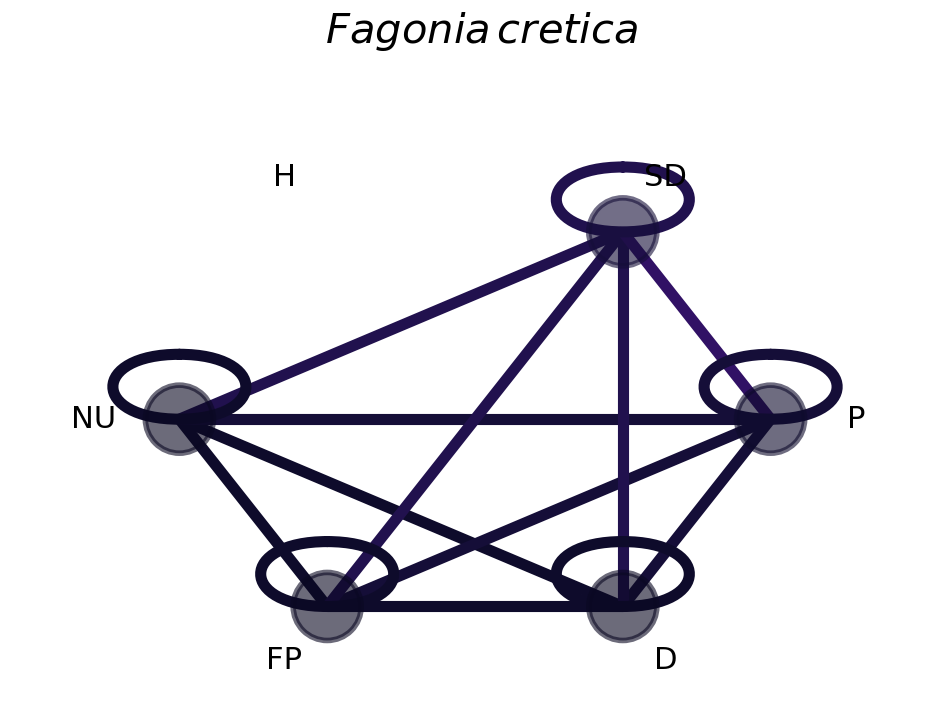

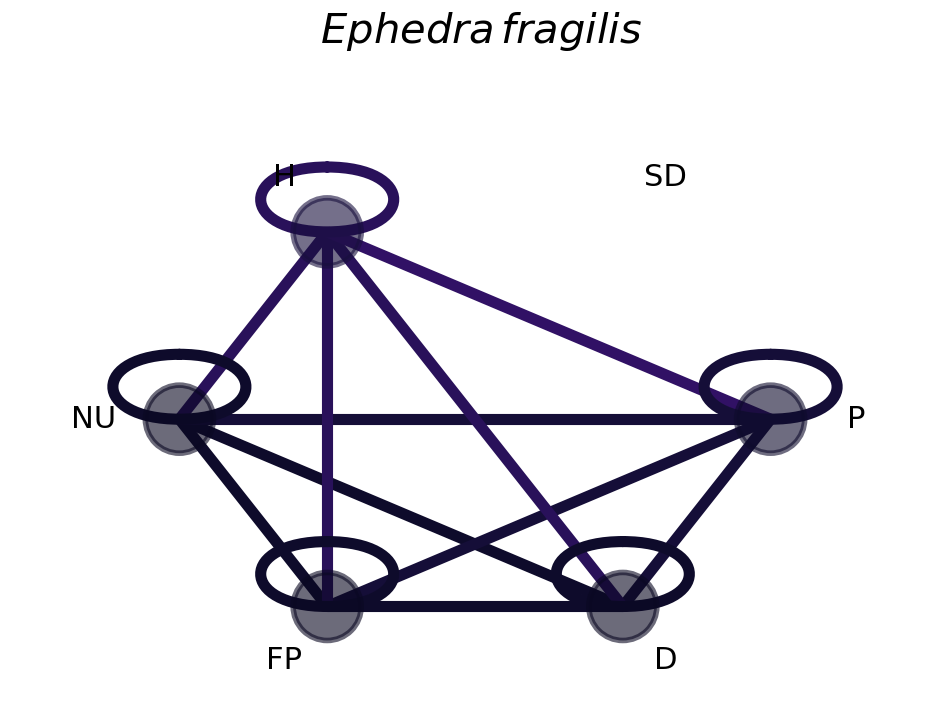

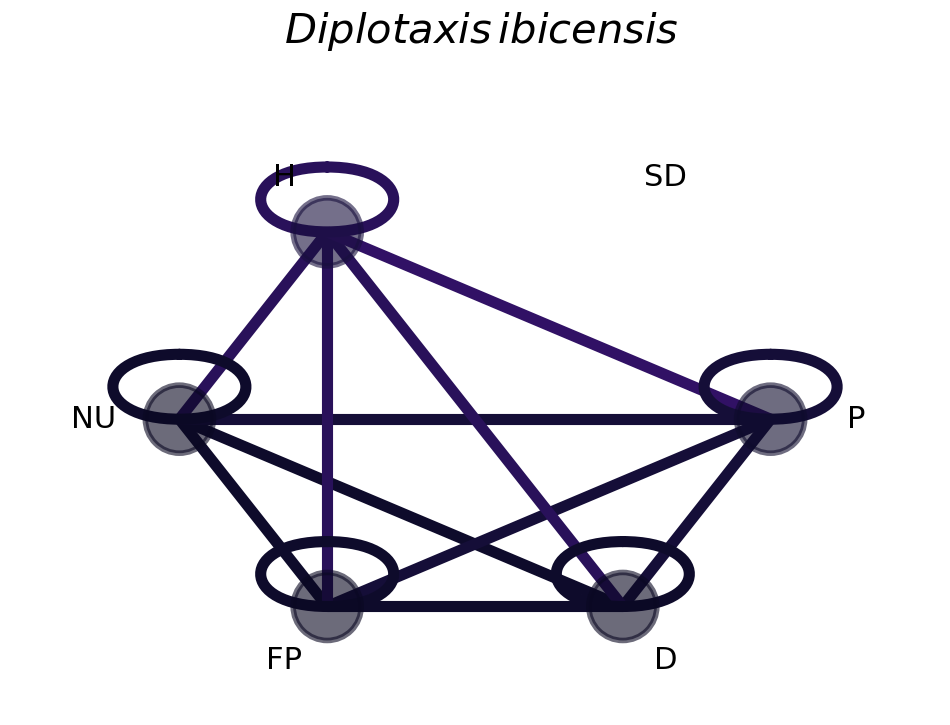

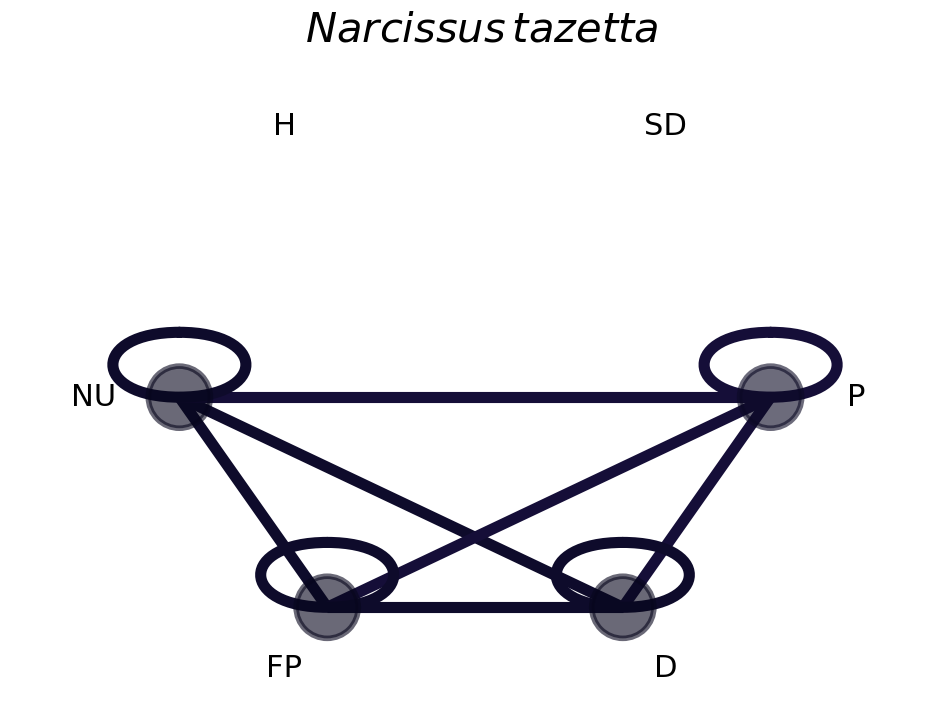

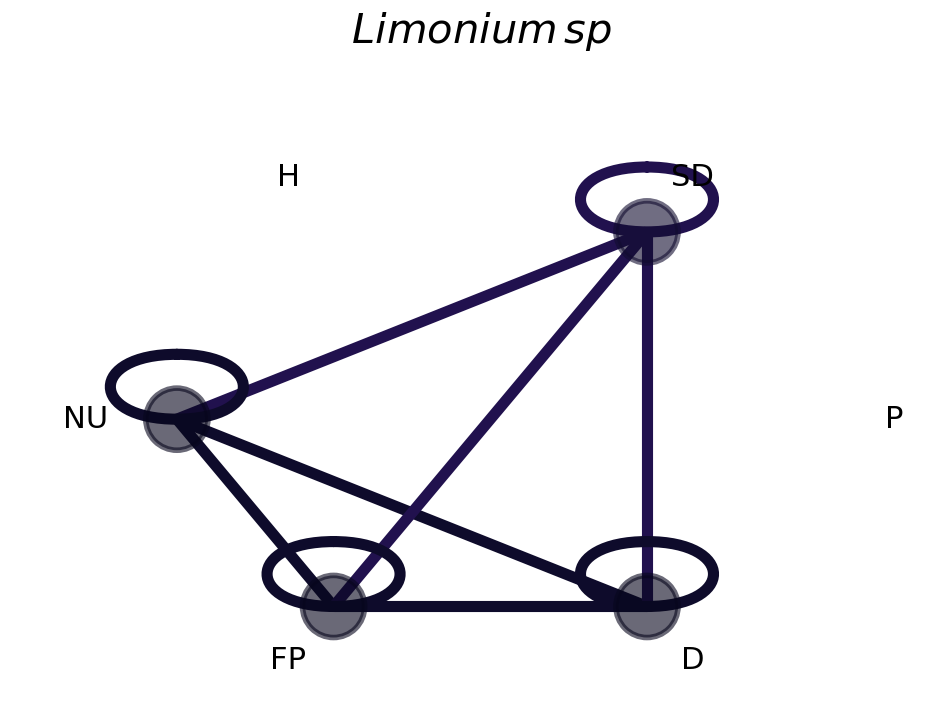

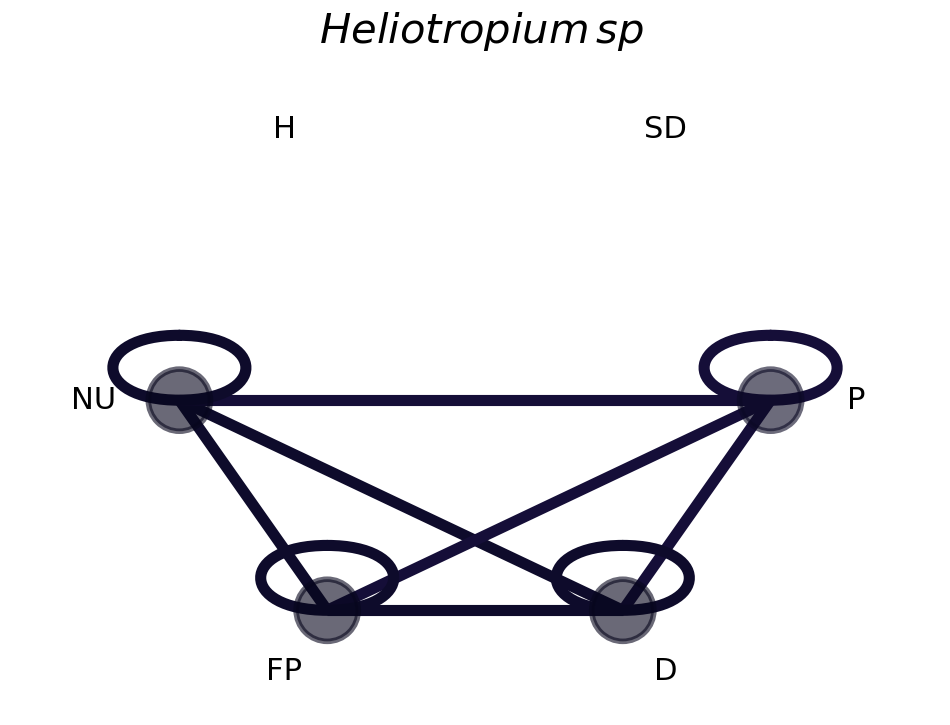

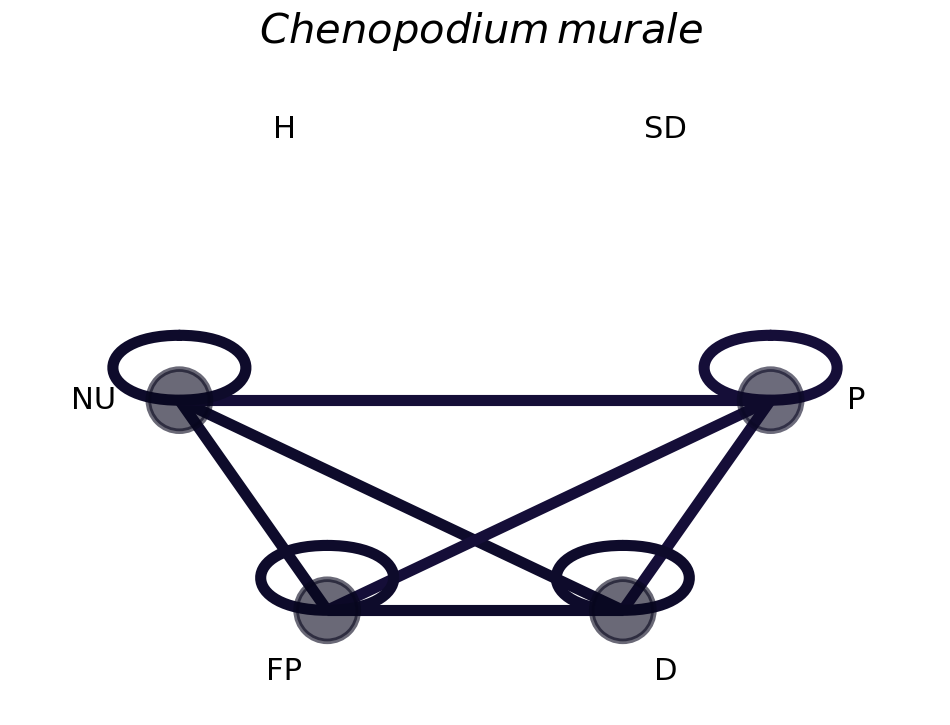

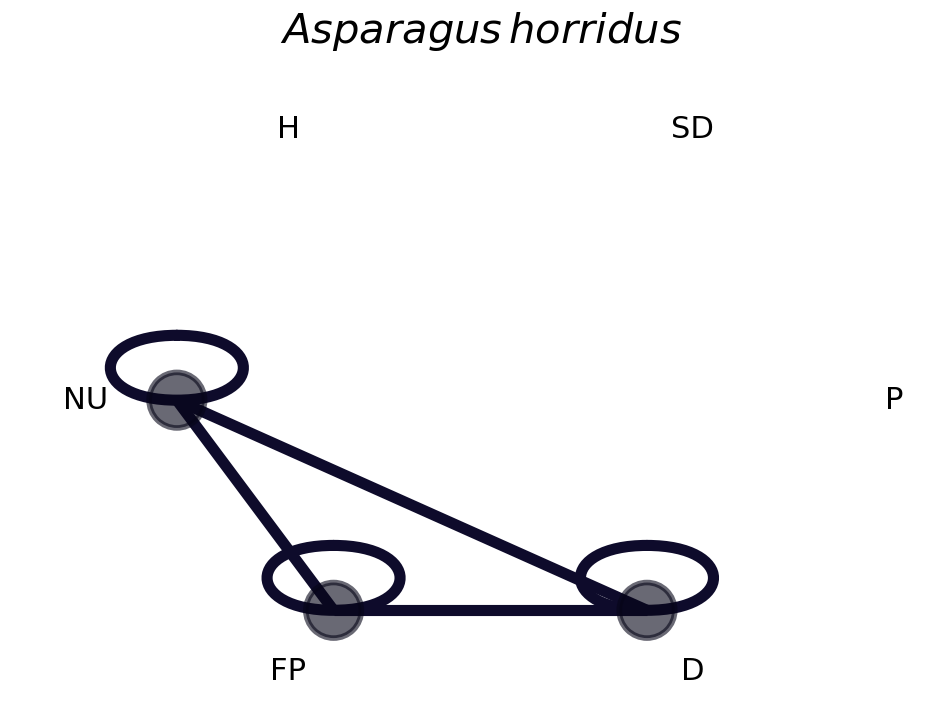

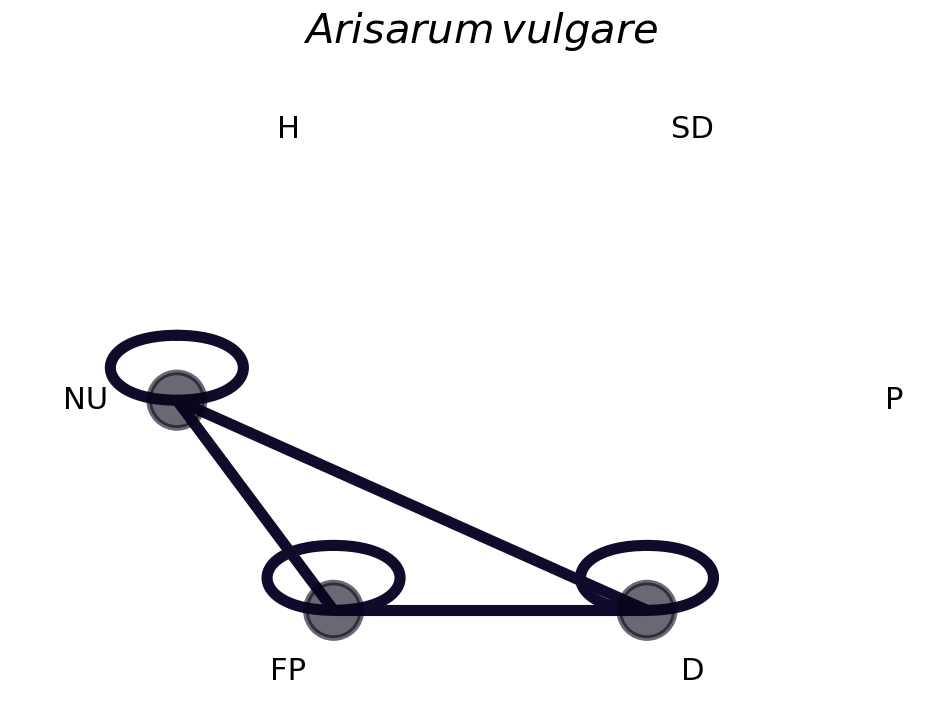

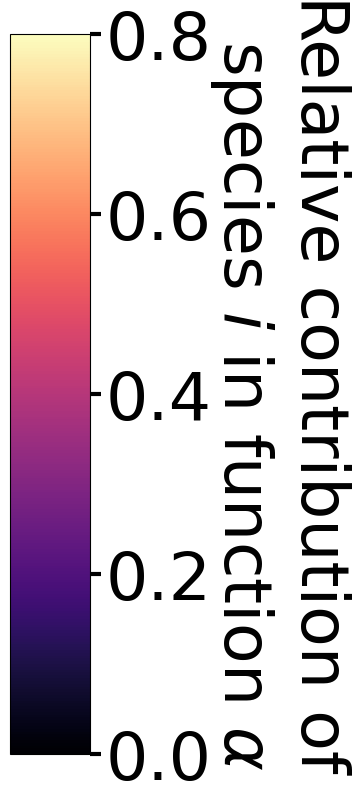

In [135]:
titles_list = [myfun.item_words(i,True) for i in species_sorted] # myfun.titles(species_sorted)  
loop_size_x = .2
loop_size_y = .2
size_label = 30
stregnth_sp=[]

for i in range(len_species):   
    fig, axs = plt.subplots(figsize=(12,8), dpi=100)
    p, p_t = myfun.p_matrix_elem(RFmap_matrix_s, elem = [species_sorted[i]] , axis=0)
    A =np.matmul(p_t,p) 
    G = nx.from_numpy_array(A, parallel_edges=False, create_using=None)
    G = nx.relabel_nodes(G, {np.array(G.nodes)[i]: labels_f[i] for i in range(len(G.nodes))} , copy=False)
    
    # Positions
    pos = myfun.layer_layout(G, layout='shell')
    dic_labels = {}
    coord_scale = 1.29
    for elem in pos:
        dic_labels[elem] = pos[elem] * coord_scale


    # Edges
    edge_color = [dict(nx.get_edge_attributes(G, 'weight'))[edge]/dict(nx.get_edge_attributes(G_T, 'weight'))[edge] for edge in G.edges()]
    width =np.array([d["weight"] for u,v,d in G.edges(data=True)])
    e = nx.draw_networkx_edges(G, 
                               pos=pos, 
                               edge_color = edge_color, 
                               edge_cmap=plt.cm.magma, 
                               edge_vmax=.8, 
                               edge_vmin=0, 
                               width=(width)*8, 
                               ax=axs,
                               )
    for self_loop_fap in axs.patches:
        self_loop_fap._connector = SelfLoop(loop_size_x,loop_size_y).style()
    axs.autoscale_view()

    # Nodes
    node_size  = np.array([G.degree(weight='weight')[node] for node in G.nodes])*400
    node_color  = np.array([G.degree(weight='weight')[node]/G_T.degree(weight='weight')[node] for node in G.nodes])
    stregnth_sp.append(node_color)

   
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_size=node_size,
                           node_color=node_color, 
                           node_shape="o", 
                           alpha=0.6, 
                           linewidths=4, 
                           ax=axs, 
                           vmin=0, 
                           vmax=1, 
                           cmap=plt.cm.magma,
                           )

    # Labels
    nx.draw_networkx_labels(G, pos=dic_labels, ax=axs, font_size=fontsize)  

    plt.axis('off')
    xlim =axs.get_xlim()
    ylim =axs.get_ylim()
    axs.set_title(titles_list[i],{'fontsize':size_label}, pad=0)
    xlim = np.array(list(axs.get_xlim()))*1.3 #make plot lims wider in the x direction not to crop nodes
    ylim = np.array(list(axs.get_ylim()))*1.3 #same in y direction
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.axis('off')
    
    if saving:
        plt.savefig(plt_dir + f'/function_function_netwotks_{species_sorted[i]}.png', bbox_inches='tight',  dpi=100 )
        plt.savefig(plt_dir + f'/function_function_netwotks_{species_sorted[i]}.pdf', bbox_inches='tight',  dpi=100 )
        plt.savefig(plt_dir + f'/function_function_netwotks_{species_sorted[i]}.jpeg', bbox_inches='tight',  dpi=100 )

#colorbar
plt.figure(figsize=(1,12), dpi=100)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, orientation='vertical',
                               cmap=plt.cm.magma  ,
                               norm=mpl.colors.Normalize(0,.8),  # vmax and vmin
                               ticks=np.arange(0, 1.2,.2))
cb.ax.tick_params(labelsize=size_label*1.6,width = 3, length = 8)
cb.set_label('Relative contribution of \n species ' + rf'$i$' + ' in function ' + rf'$\alpha$', labelpad=100, fontsize = size_label*1.6, rotation=-90)
 

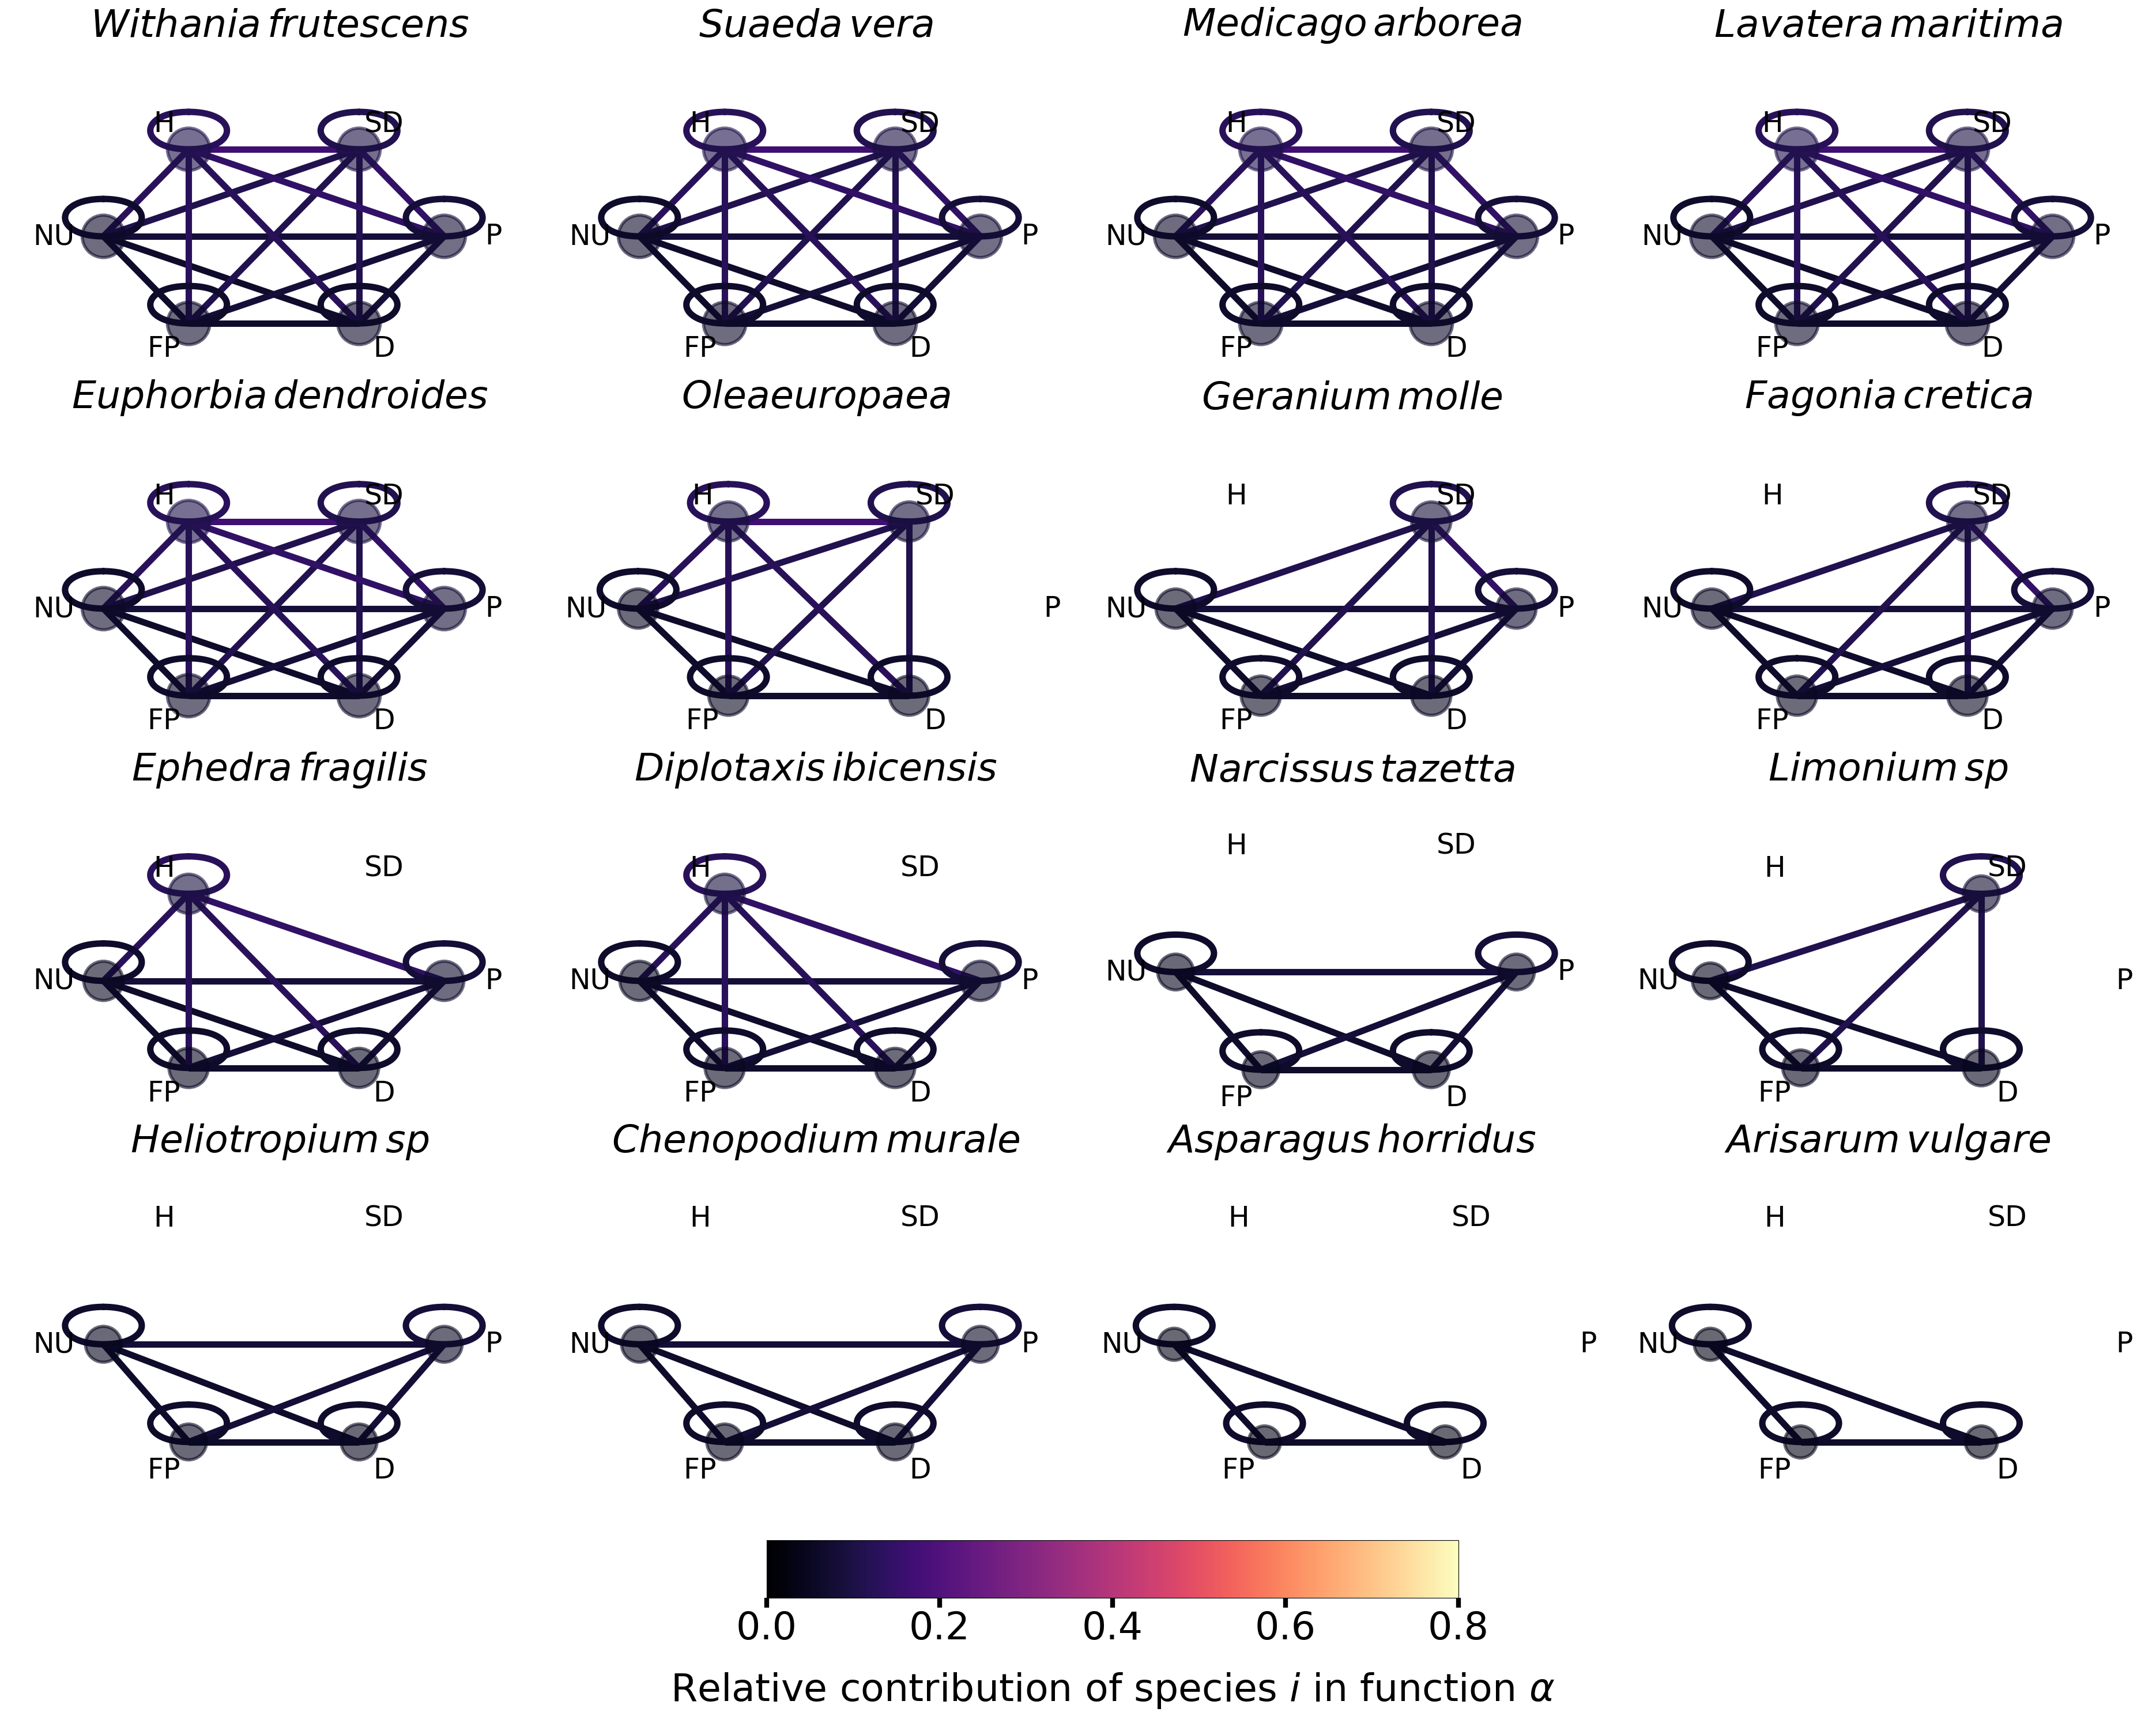

In [136]:
plt.style.context('science'+'nature')
loop_size_x = .2
loop_size_y = .2
titles_list = [myfun.item_words(i,True) for i in species_sorted] # myfun.titles(species_sorted)  
ncols=4
plot_str, plot_shape, nrows= myfun.plot_shp(len(species),ncols)
stregnth_sp=[]


fig, axs = plt.subplot_mosaic(plot_shape, figsize=(12*ncols,8*nrows), dpi=100)
fig.subplots_adjust(hspace = 0.3, wspace=0)  
for i in range(len_species):  
    item = plot_str[i]
    p, p_t= myfun.p_matrix_elem(RFmap_matrix_s, elem = [species_sorted[i]] , axis=0)
    A =np.matmul(p_t,p)  
    G = nx.from_numpy_array(A, parallel_edges=False, create_using=None)
    G = nx.relabel_nodes(G, {np.array(G.nodes)[i]: labels_f[i] for i in range(len(G.nodes))} , copy=False)
    node_color  = np.array([G.degree(weight='weight')[node]/G_T.degree(weight='weight')[node] for node in G.nodes])
    stregnth_sp.append(node_color)
    node_size  = np.array([G.degree(weight='weight')[node] for node in G.nodes])*400
    edge_color = [dict(nx.get_edge_attributes(G, 'weight'))[edge]/dict(nx.get_edge_attributes(G_T, 'weight'))[edge] for edge in G.edges()]
    pos = myfun.layer_layout(G, layout='shell')
    dic_labels = {}
    coord_scale = 1.29
    for elem in pos:
        dic_labels[elem] = pos[elem] * coord_scale
    width =np.array([d["weight"] for u,v,d in G.edges(data=True)])
    e = nx.draw_networkx_edges(G, pos=pos, edge_color = edge_color, edge_cmap=plt.cm.magma, edge_vmax=.8, edge_vmin=0, width=(width)*8, ax=axs[item])
   
    for self_loop_fap in axs[item].patches:
        self_loop_fap._connector = SelfLoop(loop_size_x,loop_size_y).style()
    axs[item].autoscale_view()

    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size,node_color=node_color, node_shape="o", alpha=0.6, linewidths=4, ax=axs[item], vmin=0, vmax=1, cmap=plt.cm.magma    )
    nx.draw_networkx_labels(G, pos=dic_labels, ax=axs[item], font_size=fontsize*1.6)  
    plt.axis('off')
    xlim =ax.get_xlim()
    ylim =ax.get_ylim()
    axs[item].set_title(titles_list[i],{'fontsize':size_label*1.6}, pad=-15)
    xlim = np.array(list(axs[item].get_xlim()))*1.3 #make plot lims wider in the x direction not to crop nodes
    ylim = np.array(list(axs[item].get_ylim()))*1.3 #same in y direction
    axs[item].set_xlim(xlim)
    axs[item].set_ylim(ylim)
    axs[item].axis('off')



cax = fig.add_axes([0.4, 0.225, 0.25, 0.025])
cb = mpl.colorbar.ColorbarBase(cax, orientation='horizontal',
                               cmap=plt.cm.magma  ,
                               norm=mpl.colors.Normalize(0,.8),  # vmax and vmin
                               ticks=np.arange(0, 1.2,.2))
cb.ax.tick_params(labelsize=size_label*1.6,width = 6, length = 12)
cb.set_label('Relative contribution of species ' + rf'$i$' + ' in function ' + rf'$\alpha$', labelpad=30, fontsize = size_label*1.6)

if saving:
    plt.savefig(plt_dir + '/function_function_netwotks.png', bbox_inches='tight', dpi=100)
    plt.savefig(plt_dir + '/function_function_netwotks.pdf', bbox_inches='tight', dpi=100)

## 4. 3. Plant-plat network


$\Pi$ is used as the adjacency matrix of the plant-plant effective interaction network. Nodes represent the plant species and edges is the expected number of shared functions by two plant species.

In [137]:
G_T = nx.from_numpy_array(P_times_P_t, parallel_edges=False, create_using=None)  
G_T = nx.relabel_nodes(G_T, {np.array(G_T.nodes)[i]: labels_p[i] for i in range(len(G_T.nodes))} , copy=False)


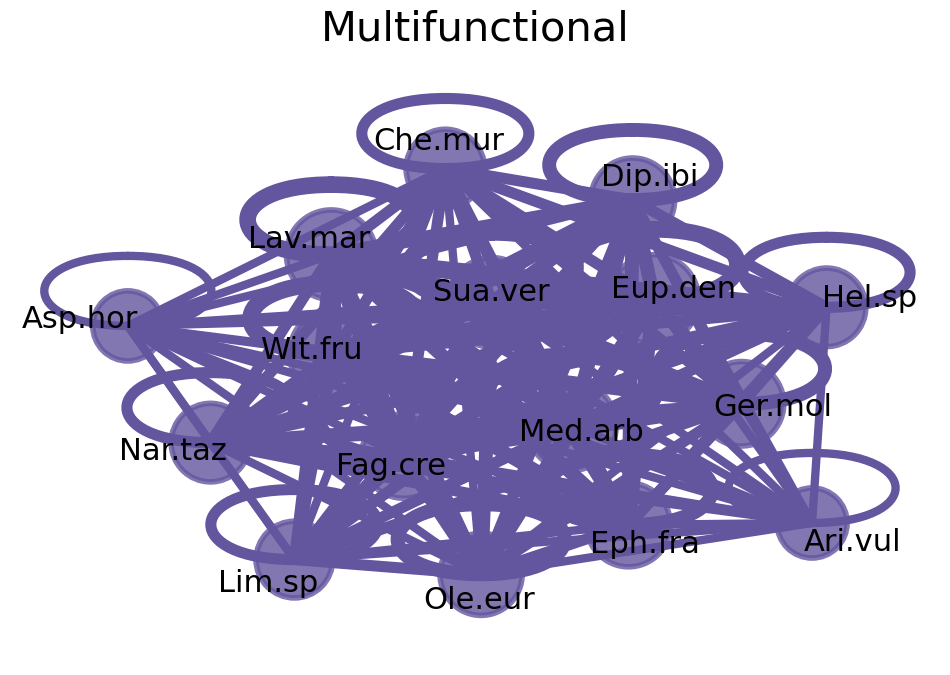

In [138]:
pos = myfun.layer_layout(G_T, layout='spring', seed=1234, k = 2.1)
dic_labels = {}
coord_scale = 1.13
for elem in pos:
    dic_labels[elem] = pos[elem] * coord_scale

fig, ax = plt.subplots(figsize=(12,8), dpi=100)    

# Edges
width =np.array([d["weight"] for u,v,d in G_T.edges(data=True)])
e = nx.draw_networkx_edges(G_T, 
                           pos=pos, 
                           edge_color = np.array([(100/256,85/256,160/256,1.0)]), 
                           width=(width)*2, 
                           ax=ax,
                           )
for self_loop_fap in ax.patches:
    self_loop_fap._connector = SelfLoop(loop_size_x,loop_size_y).style()
ax.autoscale_view()

# Nodes
node_size  = np.array([G_T.degree(weight='weight')[node] for node in G_T.nodes])*50
nx.draw_networkx_nodes(G_T, 
                       pos=pos, 
                       node_size=node_size,
                       node_color=np.array([(100/256,85/256,160/256,1.0)]), 
                       node_shape="o", 
                       alpha=0.8, 
                       linewidths=4, 
                       ax=ax,
                       )

# Labels
nx.draw_networkx_labels(G_T, pos=dic_labels, ax=ax, font_size=fontsize*1)  
plt.axis('off')
ax.set_title('Multifunctional',{'fontsize':size_label}, pad=-15)
xlim = np.array(list(ax.get_xlim()))*1.1 #make plot lims wider in the x direction not to crop nodes
ylim = np.array(list(ax.get_ylim()))*1.2 #same in y direction
ax.set_xlim(xlim);
ax.set_ylim(ylim);



The plant participation pattern of each function $\alpha$ can be disentangled from $\Pi$ by conditioning $\Pi$ only to a particular function $\alpha$. This generates a collection of networks $\Pi|^\alpha$, where 

- Each node $i$ represents a different plant species and has a node weight $P_i ^\alpha$. This is used as node size.
- A link between two plants $i$ and $j$ means that the function $\alpha$ is participated by both plants simultaneously and the link weight $\Pi|^\alpha _{ij} := P_i ^\alpha P_j ^\alpha$ quantifies that contribution. This is captured by the edge width. 


Node and edges colors are given by the node and multifunction participation indices (see Section 5).

In [139]:
stregnth_fn = []
titles_list = [function.capitalize() for function in function_sorted]
ncols=3
plot_str, plot_shape, nrows= myfun.plot_shp(len(functions),3)


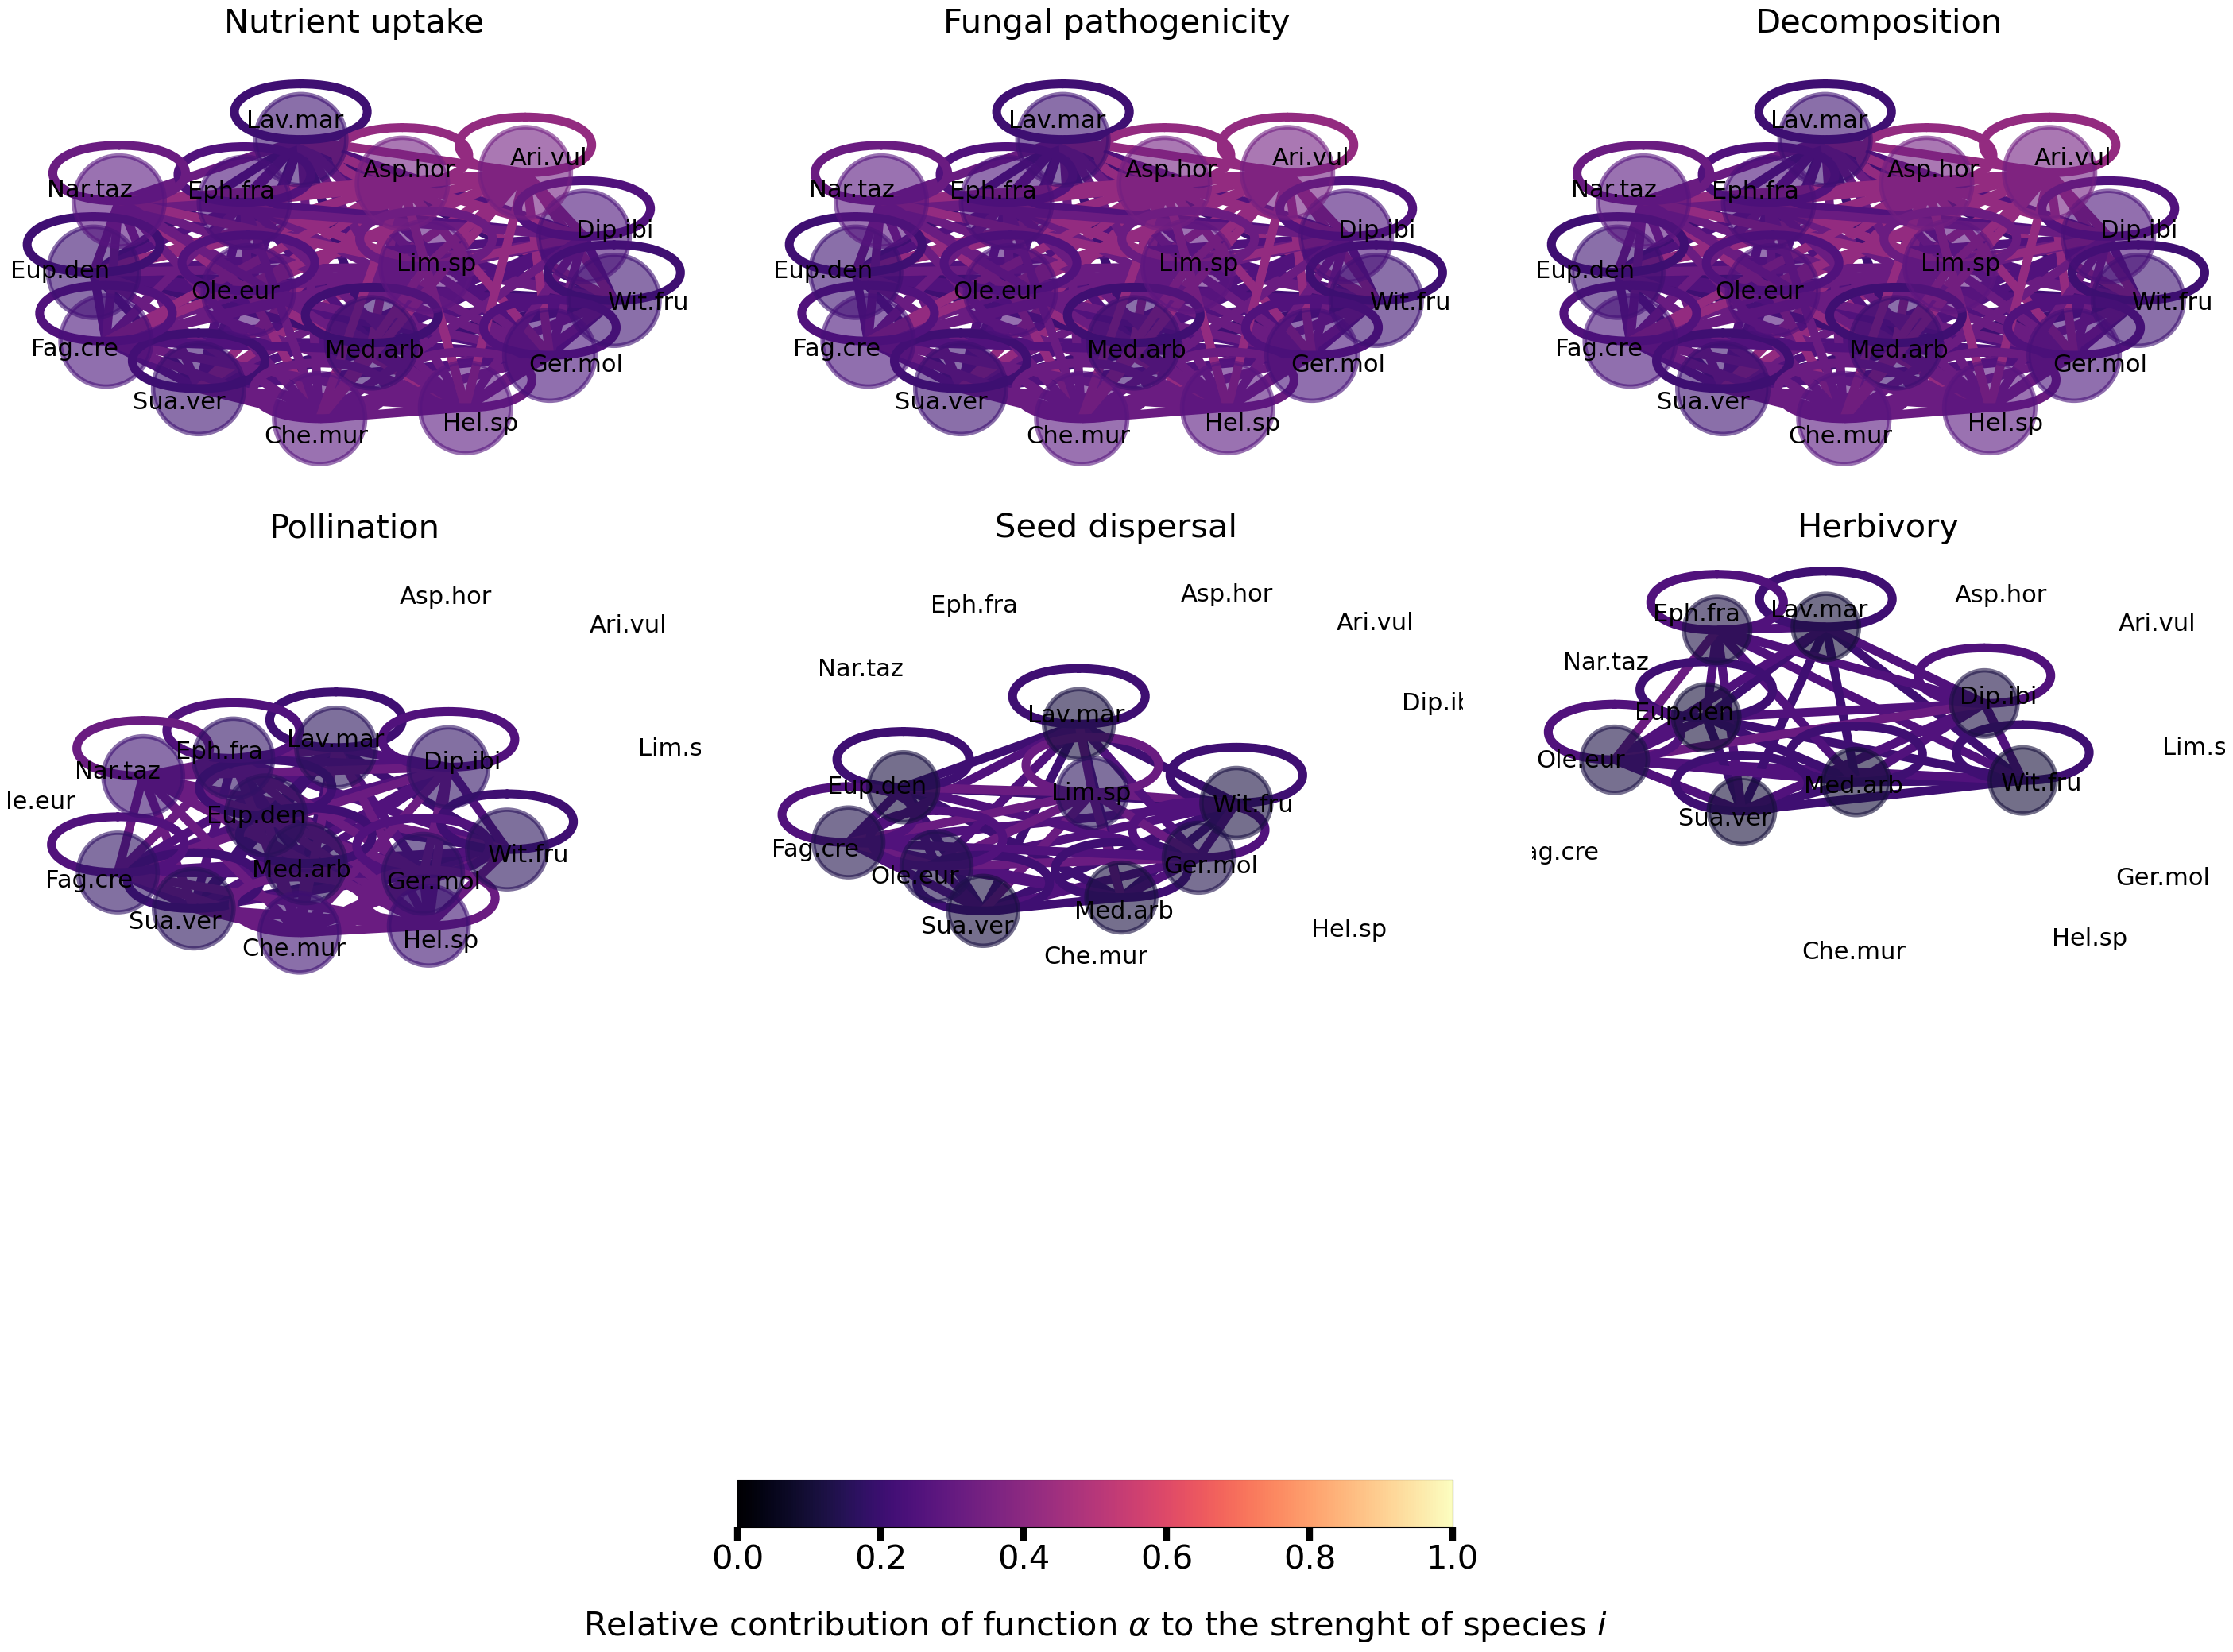

In [140]:
fig, axs = plt.subplot_mosaic(plot_shape, figsize=(12*ncols,8*ncols), dpi=100)
fig.subplots_adjust(hspace = 0.1, wspace=0.1)

for i in range(len_functions):  
    item = plot_str[i]
    p, p_t= myfun.p_matrix_elem(RFmap_matrix_s, elem = [function_sorted[i]] , axis=1)
    A = np.matmul(p,p_t)
    G = nx.from_numpy_array(A, parallel_edges=False, create_using=None)
    G = nx.relabel_nodes(G, {np.array(G.nodes)[i]: labels_p[i] for i in range(len(G.nodes))} , copy=False)
   
    # Positions
    pos = myfun.layer_layout(G, layout='spring', k=2.2, seed=13454)
    dic_labels = {}
    coord_scale = 1.13
    for elem in pos:
        dic_labels[elem] = pos[elem] * coord_scale

    # Edges
    edge_color = [dict(nx.get_edge_attributes(G, 'weight'))[edge]/dict(nx.get_edge_attributes(G_T, 'weight'))[edge] for edge in G.edges()]
    width =np.array([d["weight"] for u,v,d in G.edges(data=True)])
    e = nx.draw_networkx_edges(G, 
                               pos=pos, 
                               edge_color = edge_color, 
                               edge_cmap=plt.cm.magma, 
                               edge_vmax=.8, 
                               edge_vmin=0, 
                               width=(width)*8, 
                               ax=axs[item])
    
    for self_loop_fap in axs[item].patches:
        self_loop_fap._connector = SelfLoop(loop_size_x,loop_size_y).style()
    
    axs[item].autoscale_view()
    
    # Nodes
    node_size  = np.array([G.degree(weight='weight')[node] for node in G.nodes])*400
    node_color  = np.array([G.degree(weight='weight')[node]/G_T.degree(weight='weight')[node] for node in G.nodes])
    stregnth_fn.append(node_color)

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_size=node_size,
                           node_color=node_color, 
                           node_shape="o", 
                           alpha=0.6, 
                           linewidths=4, 
                           ax=axs[item], 
                           vmin=0, 
                           vmax=1, 
                           cmap=plt.cm.magma   
                            )
    
    # Labels
    nx.draw_networkx_labels(G, pos=dic_labels, ax=axs[item], font_size=fontsize)  
    
    plt.axis('off')
    xlim =ax.get_xlim()
    ylim =ax.get_ylim()
    axs[item].set_title(titles_list[i],{'fontsize':size_label}, pad=-15)
    xlim = np.array(list(axs[item].get_xlim()))*1.1 #make plot lims wider in the x direction not to crop nodes
    ylim = np.array(list(axs[item].get_ylim()))*1.3 #same in y direction
    axs[item].set_xlim(xlim)
    axs[item].set_ylim(ylim)
    axs[item].axis('off')


cax = fig.add_axes([0.38, 0.1, 0.25, 0.025])
cb = mpl.colorbar.ColorbarBase(cax, orientation='horizontal',
                               cmap=plt.cm.magma  ,
                               norm=mpl.colors.Normalize(0,1),  # vmax and vmin
                               ticks=np.arange(0, 1.2,.2))
cb.ax.tick_params(labelsize=size_label,width = 6, length = 12)
cb.set_label('Relative contribution of function '+ rf'$\alpha$' +' to the strenght of species ' + rf'$i$', labelpad=30, fontsize = size_label)

if saving:
    plt.savefig(plt_dir + '/plant_plant_netwotks.png', bbox_inches='tight', dpi=100)
    plt.savefig(plt_dir + '/plant_plant_netwotks.pdf', bbox_inches='tight', dpi=100)

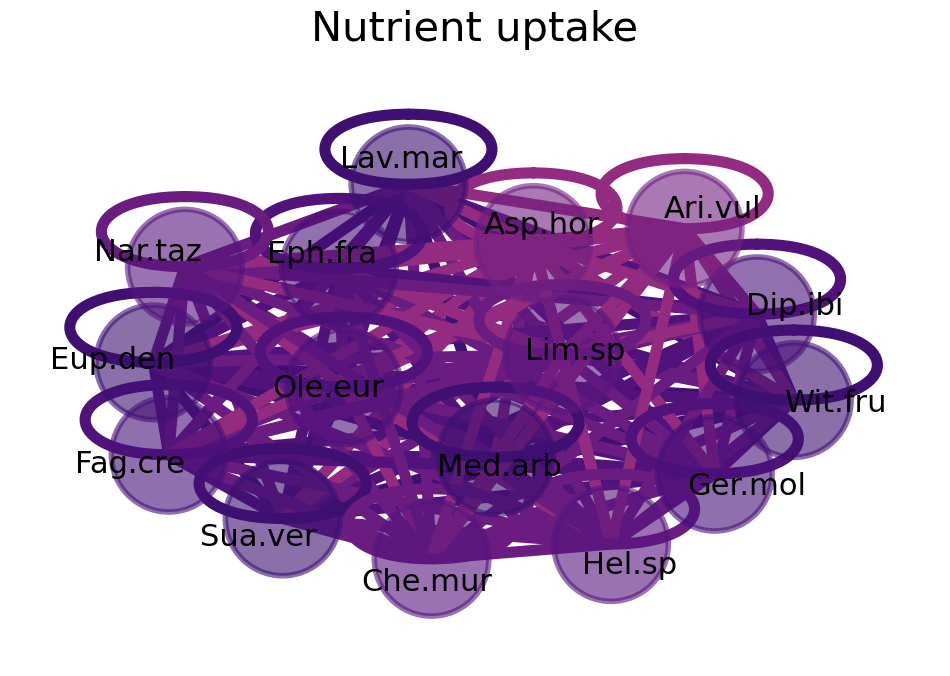

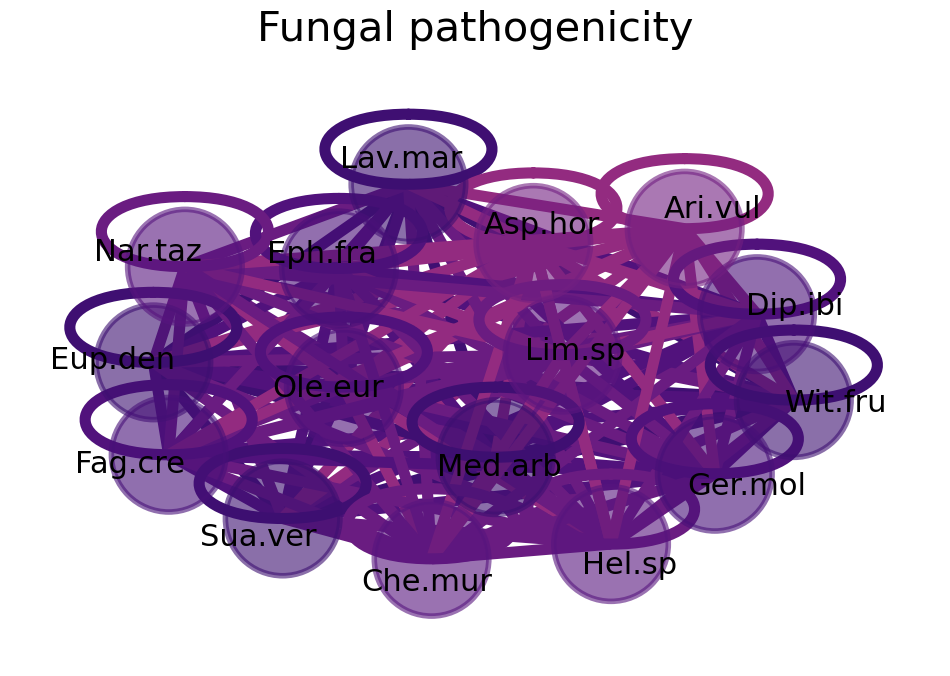

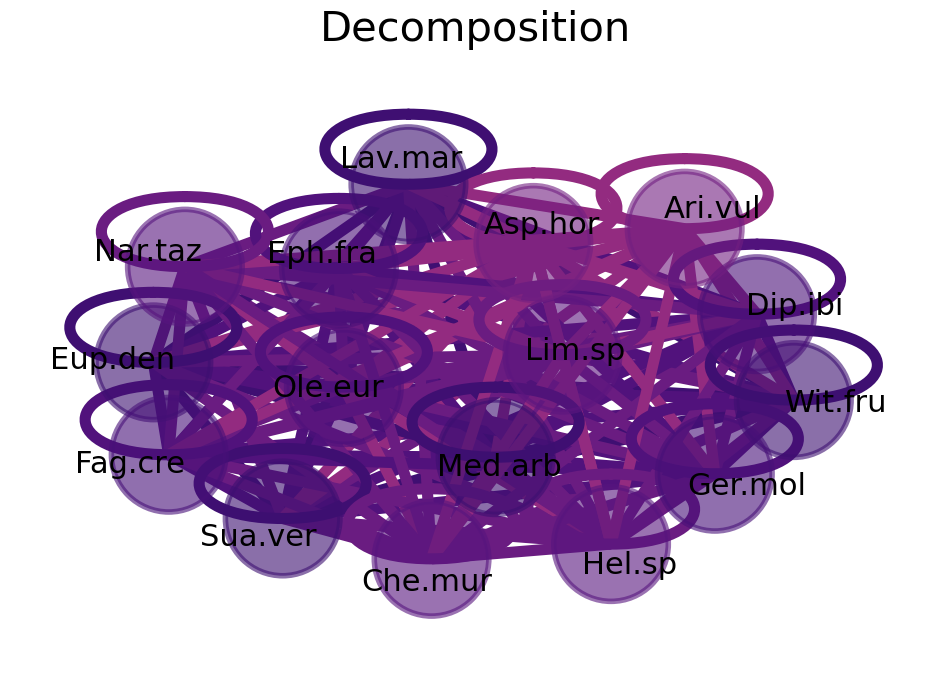

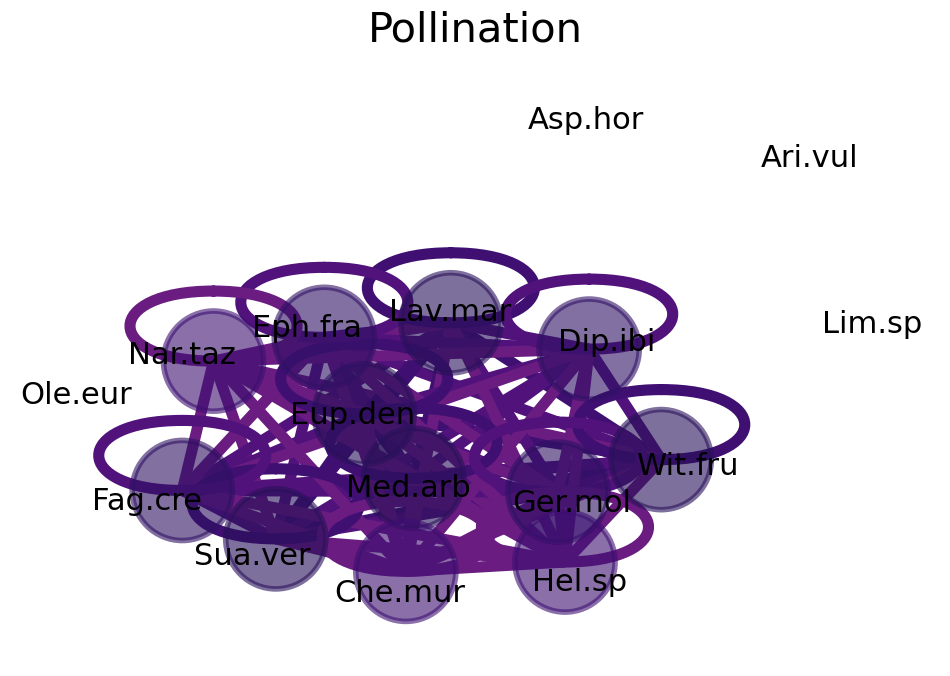

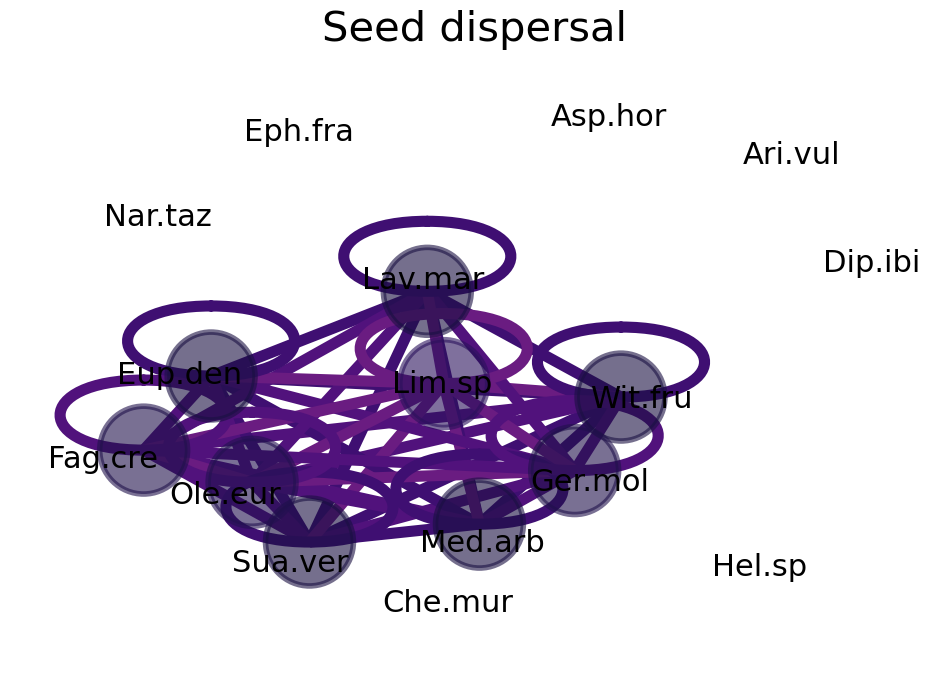

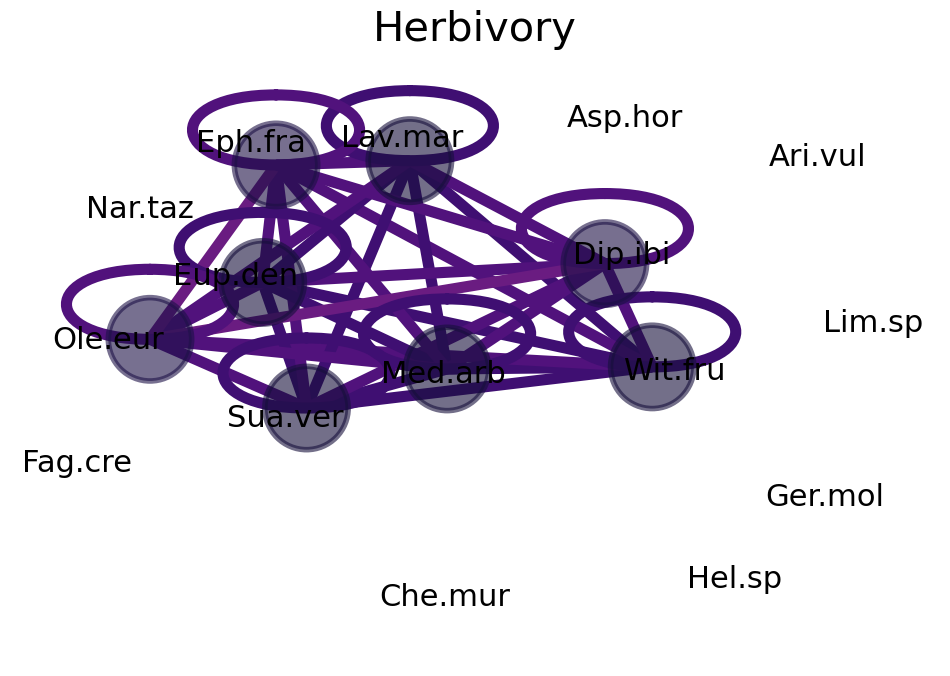

In [141]:
loop_size_x = .2
loop_size_y = .2
stregnth_fn = []

for i in range(len_functions):
    fig, axs = plt.subplots(figsize=(12,8), dpi=100)

    p, p_t= myfun.p_matrix_elem(RFmap_matrix_s, elem = [function_sorted[i]] , axis=1)
    A = np.matmul(p,p_t)
    G = nx.from_numpy_array(A, parallel_edges=False, create_using=None)
    G = nx.relabel_nodes(G, {np.array(G.nodes)[i]: labels_p[i] for i in range(len(G.nodes))} , copy=False)
    
    # Positions
    pos = myfun.layer_layout(G, layout='spring', k=2.2, seed=13454)
    dic_labels = {}
    coord_scale = 1.13
    for elem in pos:
        dic_labels[elem] = pos[elem] * coord_scale

    # Edges
    width =np.array([d["weight"] for u,v,d in G.edges(data=True)])
    edge_color = [dict(nx.get_edge_attributes(G, 'weight'))[edge]/dict(nx.get_edge_attributes(G_T, 'weight'))[edge] for edge in G.edges()]
    e = nx.draw_networkx_edges(G, 
                               pos=pos, 
                               edge_color = edge_color, 
                               edge_cmap=plt.cm.magma, 
                               edge_vmax=.8, 
                               edge_vmin=0, 
                               width=(width)*8, 
                               ax=axs
                               )

    for self_loop_fap in axs.patches:
        self_loop_fap._connector = SelfLoop(loop_size_x,loop_size_y).style()
    axs.autoscale_view()
    
    # Nodes
    node_color  = np.array([G.degree(weight='weight')[node]/G_T.degree(weight='weight')[node] for node in G.nodes])
    stregnth_fn.append(node_color)
    node_size  = np.array([G.degree(weight='weight')[node] for node in G.nodes])*400
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_size=node_size,
                           node_color=node_color, 
                           node_shape="o", 
                           alpha=0.6, 
                           linewidths=4, 
                           ax=axs, 
                           vmin=0, 
                           vmax=1, 
                           cmap=plt.cm.magma    
                           )

    # Labels
    nx.draw_networkx_labels(G, pos=dic_labels, ax=axs, font_size=fontsize)  
    
    plt.axis('off')
    xlim =axs.get_xlim()
    ylim =axs.get_ylim()
    axs.set_title(titles_list[i],{'fontsize':size_label}, pad=-100)
    xlim = np.array(list(axs.get_xlim()))*1.2 #make plot lims wider in the x direction not to crop nodes
    ylim = np.array(list(axs.get_ylim()))*1.3 #same in y direction
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.axis('off')
    if saving:
        plt.savefig(plt_dir + f'/plant_plant_netwotks_{function_sorted[i]}.png', bbox_inches='tight' , dpi=100 )
        plt.savefig(plt_dir + f'/plant_plant_netwotks_{function_sorted[i]}.pdf', bbox_inches='tight' , dpi=100 )


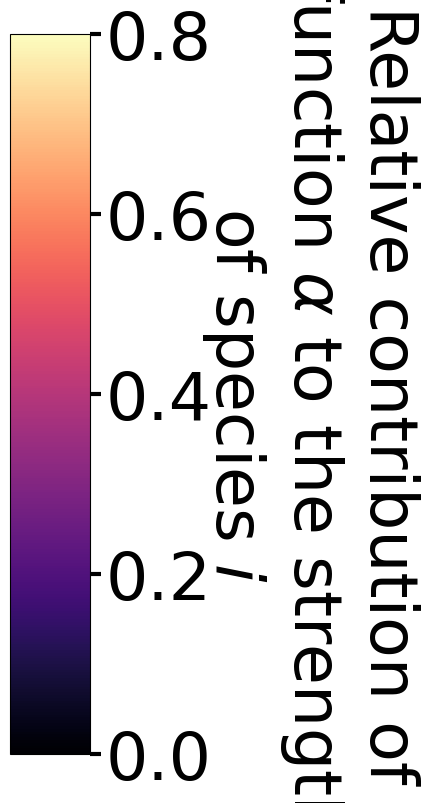

In [142]:
plt.figure(figsize=(1,12), dpi=100)
#img = plt.imshow(a,  cmap = 'viridis', vmin=v_min , vmax=v_max)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, orientation='vertical',
                               cmap=plt.cm.magma  ,
                               norm=mpl.colors.Normalize(0,.8),  # vmax and vmin
                               ticks=np.arange(0, 1.2,.2))
cb.ax.tick_params(labelsize=size_label*1.6,width = 3, length = 8)
cb.set_label('Relative contribution of\n function ' + rf'$\alpha$' + ' to the strength' +'\n'+'of species ' + rf'$i$', labelpad=150, fontsize = size_label*1.6, rotation=-90) 

if saving:
    plt.savefig(plt_dir + '/plant_plant_netwotks_cbar.png', bbox_inches='tight' , dpi=100  )
    plt.savefig(plt_dir + '/plant_plant_netwotks_cbar.pdf', bbox_inches='tight' , dpi=100  )

# 5. Rankings

## 5. 1. Participation strength rankings

Basic generalist-specialist function rankings of functions and plant species from the bipartite network with biadjacency matrix **P**  based on ordering species and functions according to the their (normalized) strength. For instance, for a given function, the strength $\sum_i P_i^\alpha$ is the normalized over all functions:

$$s(\alpha) = \frac{\sum_i P_i^\alpha}{\sum_\alpha\sum_i P_i^\alpha}$$

For plant species it is compued analogously, normalizing the strength of a species $i$ overall species.



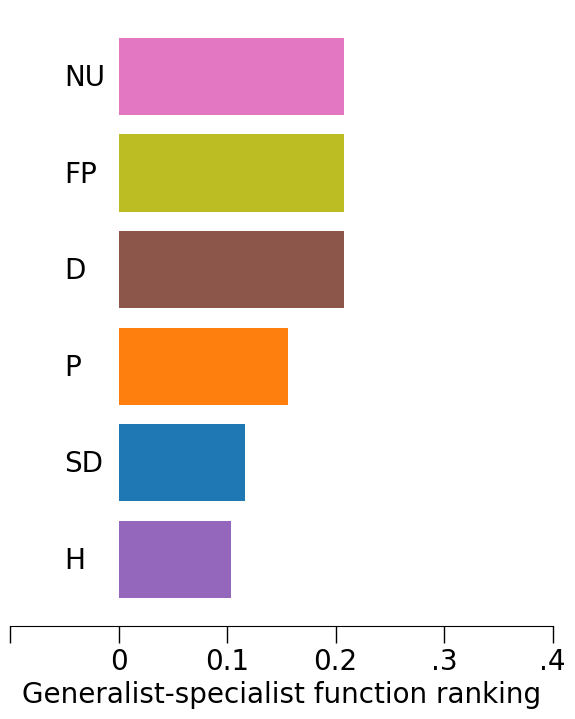

In [143]:
"""Generalist-specialist function ranking"""
dic_colors_fn = myfun.func_color(function_sorted)

fig, axs = plt.subplots(figsize=(7,8), dpi=100)  
fontsize=20
position = np.arange(1,len_species+1)
max_len = -1
left = np.zeros(len_species)
position = np.arange(14,14+len_functions+1)
position = np.arange(0,0+len_functions+1)
for ele in labels_f:
    if len(ele) > max_len:
        max_len = len(ele)
for i in range(len_functions):
    axs.text((max_len/40)*(-1), position[i]+ 0.1, labels_f[i], fontsize =fontsize, horizontalalignment = 'left')
    axs.barh(position[i], degree_fn[i],left=0, color = dic_colors_fn[function_sorted[i]])
axs.invert_yaxis()
for pos in ['right', 'top', 'left']:
    axs.spines[pos].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)
axs.set_xticks(np.arange(-.1,.5,0.1))
axs.set_xticklabels(["", '0', '0.1', '0.2', '.3', '.4'])
axs.set_yticks([])
axs.set_xlabel('Generalist-specialist function ranking', fontsize = fontsize)


if saving:
    plt.savefig(plt_dir + '/rank_fn_figure2.pdf', bbox_inches='tight' ,  dpi=100)
    plt.savefig(plt_dir + '/rank_fn_figure2.png', bbox_inches='tight' ,  dpi=100)

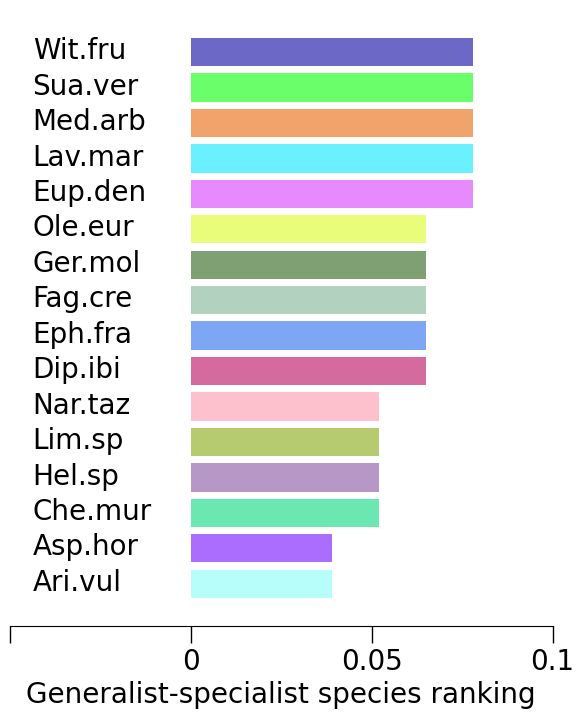

In [144]:
"""Generalist-specialist plants ranking"""
dic_colors_sp = myfun.func_color(species_sorted)

fig, axs = plt.subplots(figsize=(7,8), dpi=100)  
fontsize=20
max_len = -1
left = np.zeros(len_species)
position = np.arange(1,len_species+1)
for ele in labels_p:
    if len(ele) > max_len:
        max_len = len(ele)
for i in range(len_species):
    axs.text((max_len/160)*(-1), position[i]+ 0.2, labels_p[i], fontsize =fontsize, horizontalalignment = 'left')
    axs.barh(position[i], degree_sp[i],left=0, color = dic_colors_sp[species_sorted[i]])
axs.invert_yaxis()
for pos in ['right', 'top', 'left']:
    axs.spines[pos].set_visible(False)

axs.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)
axs.set_xticks(np.arange(-.05,.15,0.05))
axs.set_xticklabels(["", '0', '0.05', '0.1'])
axs.set_yticks([])
axs.set_xlabel('Generalist-specialist species ranking', fontsize = fontsize)

if saving:
    plt.savefig(plt_dir + '/rank_sp_figure2.pdf', bbox_inches='tight' ,  dpi=100)
    plt.savefig(plt_dir + '/rank_sp_figure2.png', bbox_inches='tight' ,  dpi=100)

## 5. 2. Multifunctional species ranking

This rankinkg quantifies the importance of resource $i$ in connecting ecological functions in terms of the multilayer participation index of plant species $i$ in function $\alpha$:

$$MPI(i, \alpha)= \frac{\sum_\beta \Phi^{\alpha \beta}|_i}{\sum_\beta \Phi^{\alpha \beta}}$$

The resulting keystoneness vector of plant species $i$ is composed of the $MPI$s for each function (each of these MPIs is color coded).

Species are sorted in order of decreasing keystoneness providing a score.

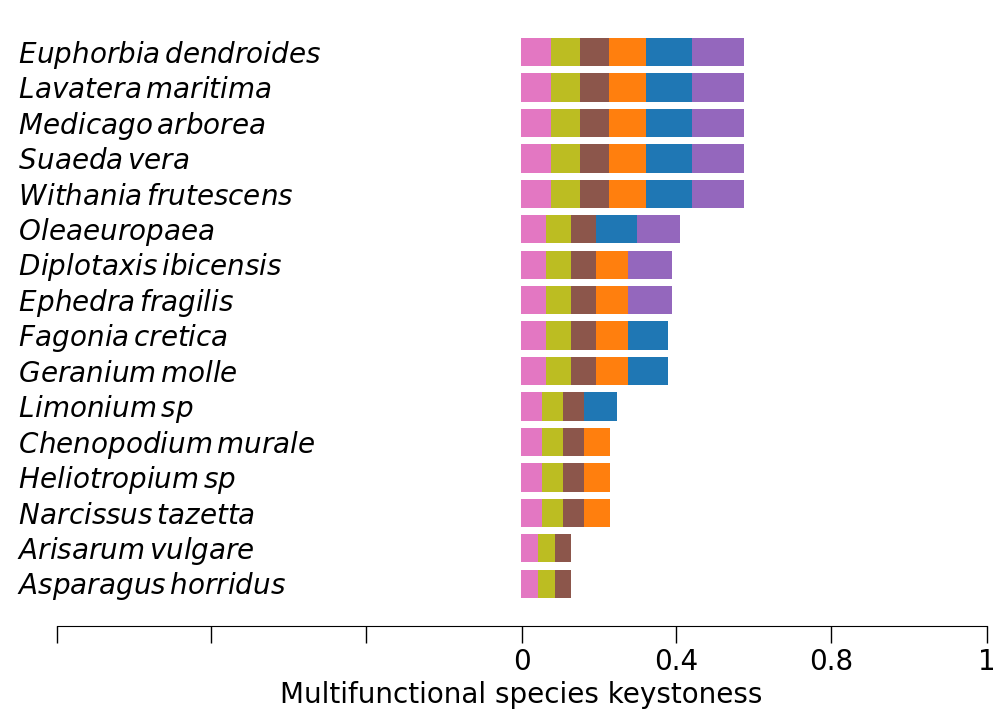

In [145]:
sums_sp_rank, stregnth_sp_rank, labels_sp_rank = myfun.rank(stregnth_sp, species_sorted)

labels_sp_rank_tit = myfun.titles(labels_sp_rank, line_sep=False)

fig, axs = plt.subplots(figsize=(12,8), dpi=100)  
fontsize=20
position = np.arange(1,len_species+1)
max_len = -1
left = np.zeros(len_species)
label_width = np.zeros(len_species)
position = np.arange(1,len_species+1)
for ele in labels_sp_rank_tit:
    if len(ele) > max_len:
        max_len = len(ele)
for i in range(len_species):
    axs.text((max_len/25)*(-1), position[i]+ 0.3, labels_sp_rank_tit[i], fontsize =fontsize, horizontalalignment = 'left')
    label_width = np.zeros(len_species)
    for j in range(len(function_sorted)):
        axs.barh(position[i], stregnth_sp_rank[i][j],left=label_width, color = dic_colors_fn[function_sorted[j]])
        label_width += stregnth_sp_rank[i][j]

axs.invert_yaxis()
for pos in ['right', 'top', 'left']:
    axs.spines[pos].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)
axs.set_xticks(np.arange(-1.2,1.5,0.4))
axs.set_xticklabels(["","","", '0', '0.4', '0.8', '1'])
axs.set_yticks([])
axs.set_xlabel('Multifunctional species keystoness', fontsize = fontsize)

if saving:
    plt.savefig(plt_dir + '/rank_figure3.png', bbox_inches='tight' ,  dpi=100)
    plt.savefig(plt_dir + '/rank_figure3.pdf', bbox_inches='tight' ,  dpi=100)


In [146]:
len_species

16

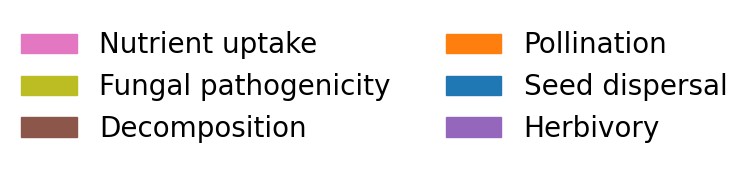

In [147]:
labels = [function.capitalize() for function in function_sorted]
handles = [plt.Rectangle((0,0),1,1, color=dic_colors_fn[fn]) for fn in function_sorted]
############ARREGLAR TITLES FINCTION SORTED NO FUNCIONA LA FUNCION
fig, ax = plt.subplots(figsize=(5,2), dpi=100)
ax.legend(handles =handles,labels=labels,fontsize= fontsize,loc= 'center', frameon=False, ncol= 2)
plt.axis('off')

if saving:
    plt.savefig(plt_dir + '/rank_figure3_legend.pdf', bbox_inches='tight',  dpi=100 )
    plt.savefig(plt_dir + '/rank_figure3_legend.png', bbox_inches='tight',  dpi=100 )

## 5. 3. 

This rankinkg quantifies the importance of function $\alpha$ in connecting plant species in terms of the multilayer participation index of function $\alpha$ in plant species $i$:

$$MPI(\alpha, i)= \frac{\sum_j \Pi_{ij}|^\alpha}{\sum_j \Pi_{ij}}$$

The resulting keystoneness vector of function $\alpha$ is composed of the $MPI$s for each plant species (each of these MPIs is color coded).

Functions are sorted in order of decreasing keystoneness providing a score.

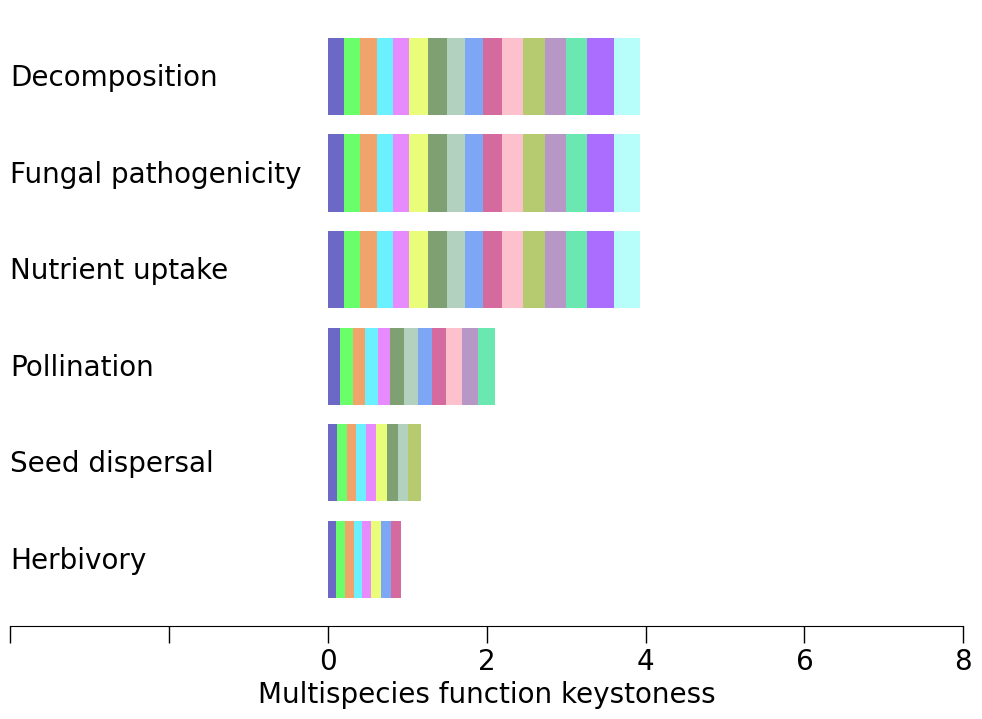

In [148]:
sums_fn_rank, stregnth_fn_rank, labels_fn_rank = myfun.rank(stregnth_fn, function_sorted)
labels_fn_rank = [function.capitalize() for function in labels_fn_rank]


fig, axs = plt.subplots(figsize=(12.3,8), dpi=100)  
fontsize=20
position = np.arange(1,len_functions+1)
max_len = -1
left = np.zeros(len_functions)
label_width = np.zeros(len_functions)
position = np.arange(1,len_functions+1)
for ele in labels_fn_rank:
    if len(ele) > max_len:
        max_len = len(ele)
for i in range(len_functions):
    axs.text((max_len/5)*(-1), position[i]+ 0.1, labels_fn_rank[i], fontsize =fontsize, horizontalalignment = 'left')
    label_width = np.zeros(len_functions)
    for j in range(len(species_sorted)):
        axs.barh(position[i], stregnth_fn_rank[i][j],left=label_width, color = dic_colors_sp[species_sorted[j]])
        label_width += stregnth_fn_rank[i][j]
axs.invert_yaxis()
for pos in ['right', 'top', 'left']:
    axs.spines[pos].set_visible(False)

axs.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)
axs.set_xticks(np.arange(-4,10,2))
axs.set_xticklabels(["","", '0', '2', '4', '6', '8'])
axs.set_yticks([])
axs.set_xlabel('Multispecies function keystoness', fontsize = fontsize)


if saving:
    plt.savefig(plt_dir + '/rank_figure4.pdf', bbox_inches='tight' ,  dpi=100)
    plt.savefig(plt_dir + '/rank_figure4.png', bbox_inches='tight' ,  dpi=100)

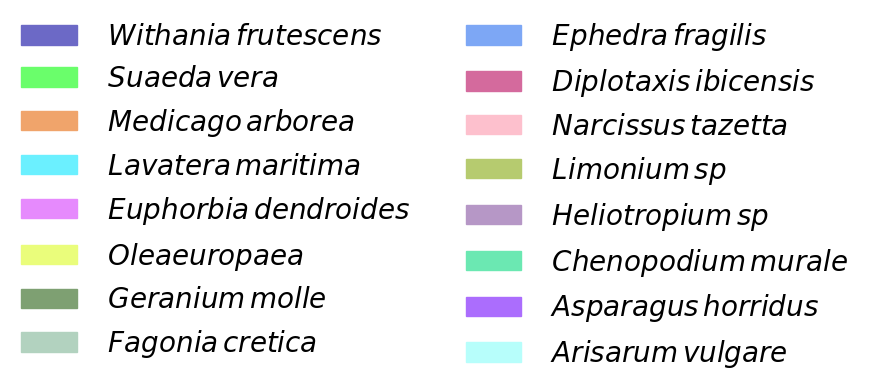

In [149]:
labels = species_sorted
handles = [plt.Rectangle((0,0),1,1, color=dic_colors_sp[sp]) for sp in species_sorted]
labels = myfun.titles(species_sorted, line_sep = False)
fig, ax = plt.subplots(figsize=(5,1), dpi=100)
ax.legend(handles =handles,labels=labels,fontsize= fontsize,loc= 'center', frameon=False, ncol= 2)
plt.axis('off')

if saving:

    plt.savefig(plt_dir + '/rank_figure4_legend.pdf', bbox_inches='tight',  dpi=100 )
    plt.savefig(plt_dir + '/rank_figure4_legend.png', bbox_inches='tight',  dpi=100 )

## 5. 4. Scatter plot of species ranking vs species abundance and vegetation cover

Additionally, the scatter plot of the multifunctional species keystoneness index vs both species abundance and vegetation cover of the plant species is generated.

The plot is semi-log to as both abundances and cover span several orders of magnitude. 

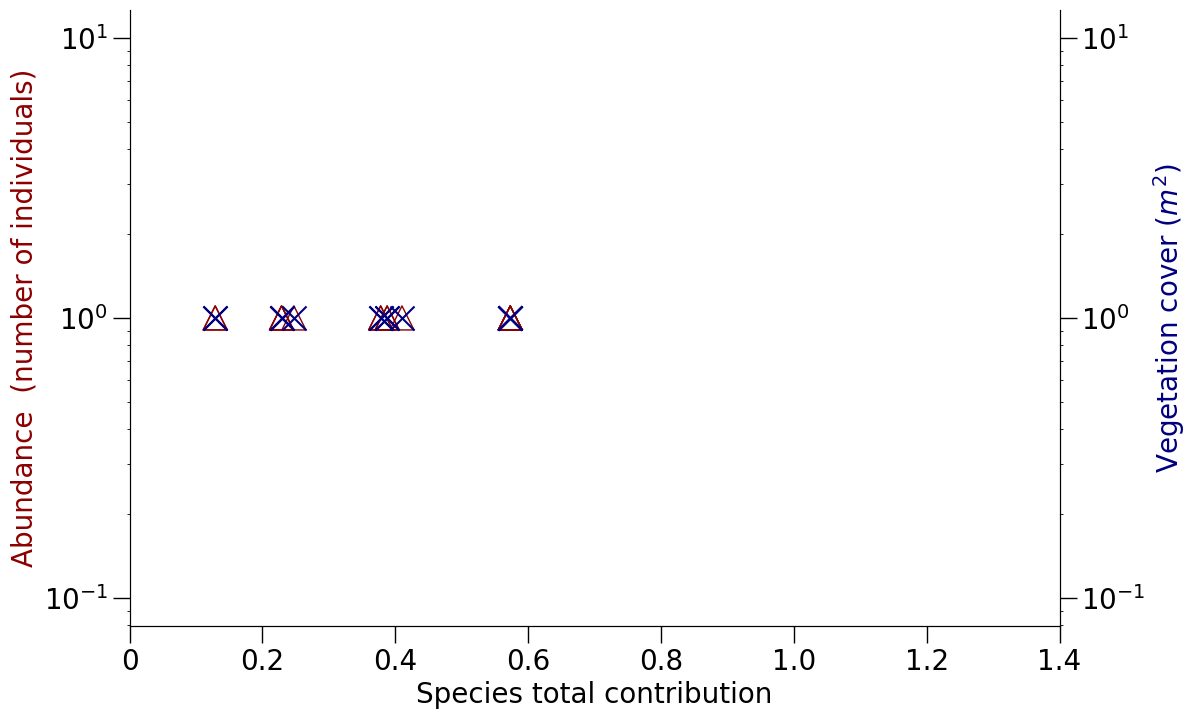

In [150]:
labels_sp_rank_low = [lab.capitalize() for lab in labels_sp_rank]
contr_sp = np.sum(stregnth_sp_rank, axis=1)
abundance_sp = [RFmap_matrix[RFmap_matrix['plant_sp'] ==plant]['abundance'].to_numpy()[0] for plant in labels_sp_rank_low ]
cover_sp = [RFmap_matrix[RFmap_matrix['plant_sp'] ==plant]['cover'].to_numpy()[0] for plant in labels_sp_rank_low ]


fontsize=20
fig,ax = plt.subplots(figsize=(12,8), dpi=100)  
ax2=ax.twinx()

ax.scatter(contr_sp,abundance_sp,marker="^",s=300,facecolors='none', edgecolors='darkred')
ax.set_ylabel("Abundance  (number of individuals)",color='darkred',fontsize=fontsize)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)

ax2.scatter(contr_sp, cover_sp,marker="x",c='navy', s=300)
ax2.set_ylabel("Vegetation cover ("+ r'$m^2$'+')' ,color="navy",fontsize=fontsize)
ax2.set_yscale('log')
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)

ax.set_xlabel("Species total contribution",color="k",fontsize=fontsize)
ax.set_xticks(np.arange(0,1.6,.2))
ax.set_xticklabels(['0', '0.2','0.4','0.6','0.8','1.0','1.2','1.4'], minor=False, fontsize=fontsize);

if saving:
    plt.savefig(plt_dir + '/abundance_cover_corr.pdf', bbox_inches='tight',  dpi=100 )
    plt.savefig(plt_dir + '/abundance_cover_corr.png', bbox_inches='tight',  dpi=100 )

In [151]:
print("Correlation with abundance")
print("_______________________________")
print('Pearson correlation:', scipy.stats.pearsonr(contr_sp, abundance_sp))
print('Spearman correlation:', scipy.stats.spearmanr(contr_sp, abundance_sp))

print("")
print("Correlation with log-Abundance")
print("_______________________________")
print('Pearson correlation:', scipy.stats.pearsonr(contr_sp, np.log10(abundance_sp)))
print('Spearman correlation:', scipy.stats.spearmanr(contr_sp, np.log10(abundance_sp)))


print("")
print("Correlation with cover")
print("_______________________________")
print('Pearson correlation:', scipy.stats.pearsonr(contr_sp, cover_sp))
print('Spearman correlation:', scipy.stats.spearmanr(contr_sp, cover_sp))

print("")
print("Correlation with log-cover")
print("_______________________________")
print('Pearson correlation:', scipy.stats.pearsonr(contr_sp, np.log10(cover_sp)))
print('Spearman correlation:', scipy.stats.spearmanr(contr_sp, np.log10(cover_sp)))


# show the upper results in a table instead of a sucessive print

Correlation with abundance
_______________________________
Pearson correlation: PearsonRResult(statistic=nan, pvalue=nan)
Spearman correlation: SignificanceResult(statistic=nan, pvalue=nan)

Correlation with log-Abundance
_______________________________
Pearson correlation: PearsonRResult(statistic=nan, pvalue=nan)
Spearman correlation: SignificanceResult(statistic=nan, pvalue=nan)

Correlation with cover
_______________________________
Pearson correlation: PearsonRResult(statistic=nan, pvalue=nan)
Spearman correlation: SignificanceResult(statistic=nan, pvalue=nan)

Correlation with log-cover
_______________________________
Pearson correlation: PearsonRResult(statistic=nan, pvalue=nan)
Spearman correlation: SignificanceResult(statistic=nan, pvalue=nan)


/home/marcuevas/anaconda3/envs/marx/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/marcuevas/anaconda3/envs/marx/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


# 6. Pruning analysis of $\Phi$ and $\Pi$

in order to better understand how similar functions are, edges are secuentially pruned in $\Phi$. The size of the largest connected component (LCC) is monitored as well as the area enclosed under this curve (AUC) as pruning progresses. The analysis is performed in ascending (red) and decreasing (blue) order of edge weight. 

A similar analysis can then be performed in $\Pi$, to further understand the clustering properties of plant species. 

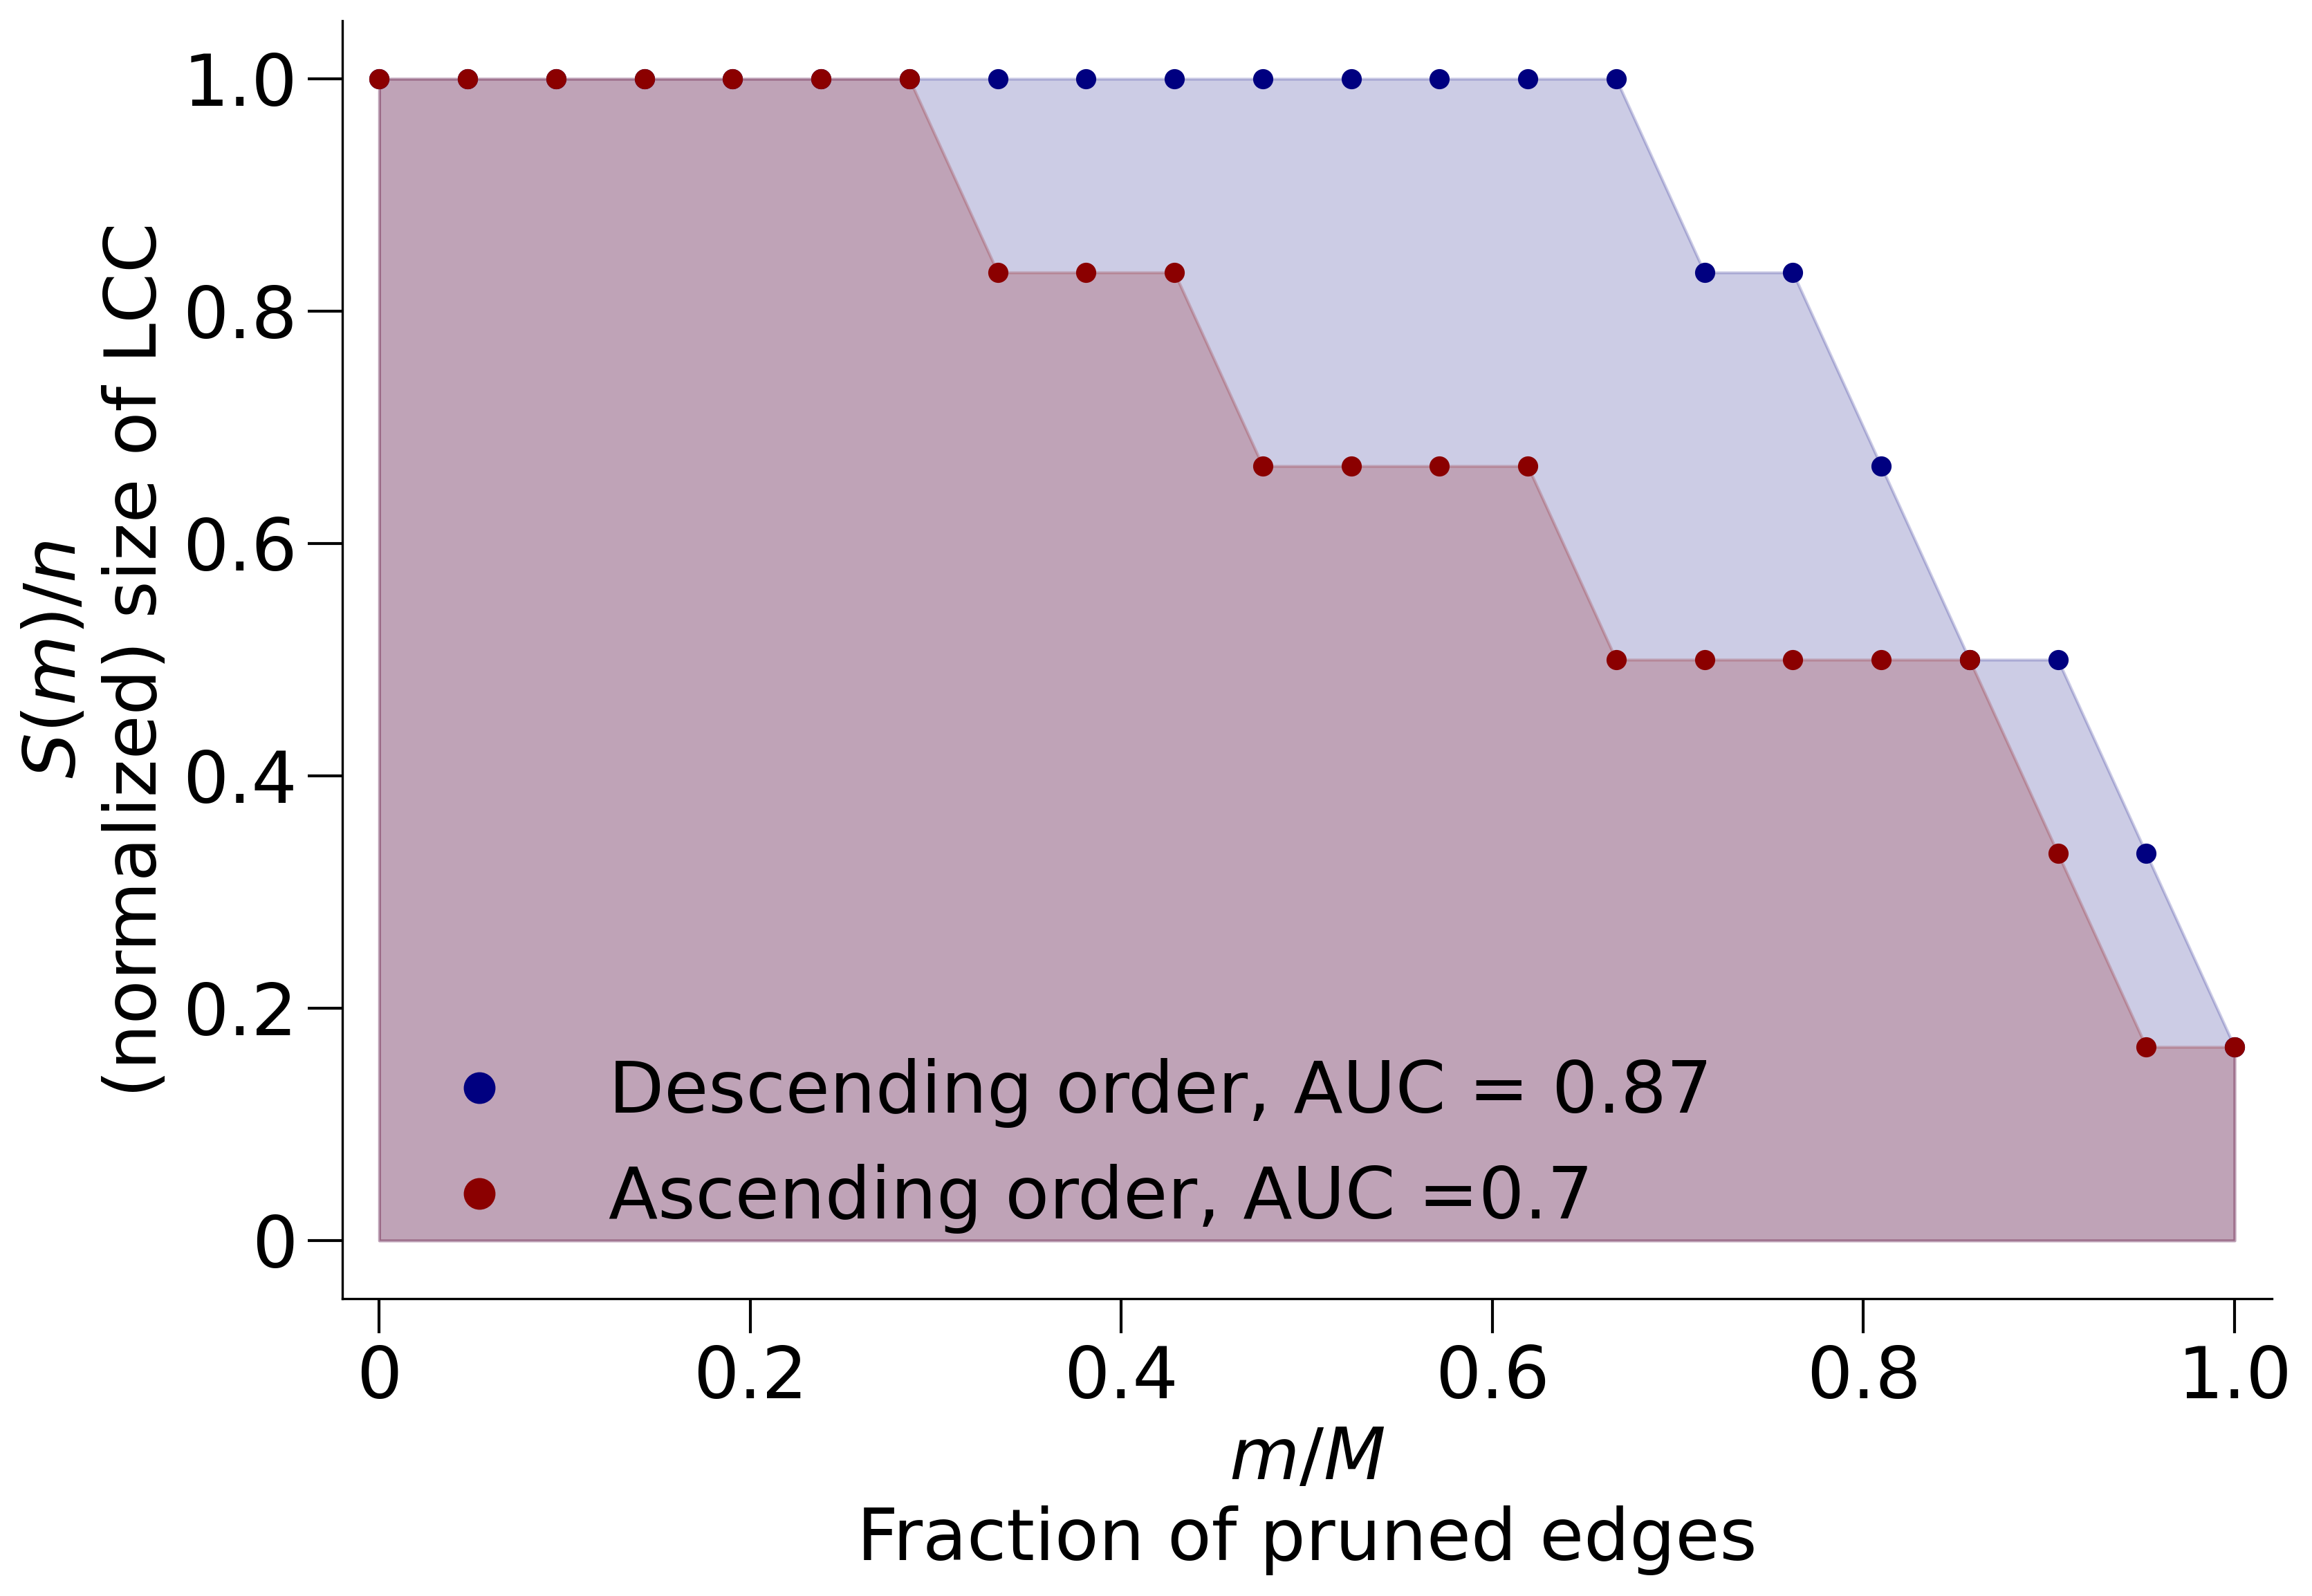

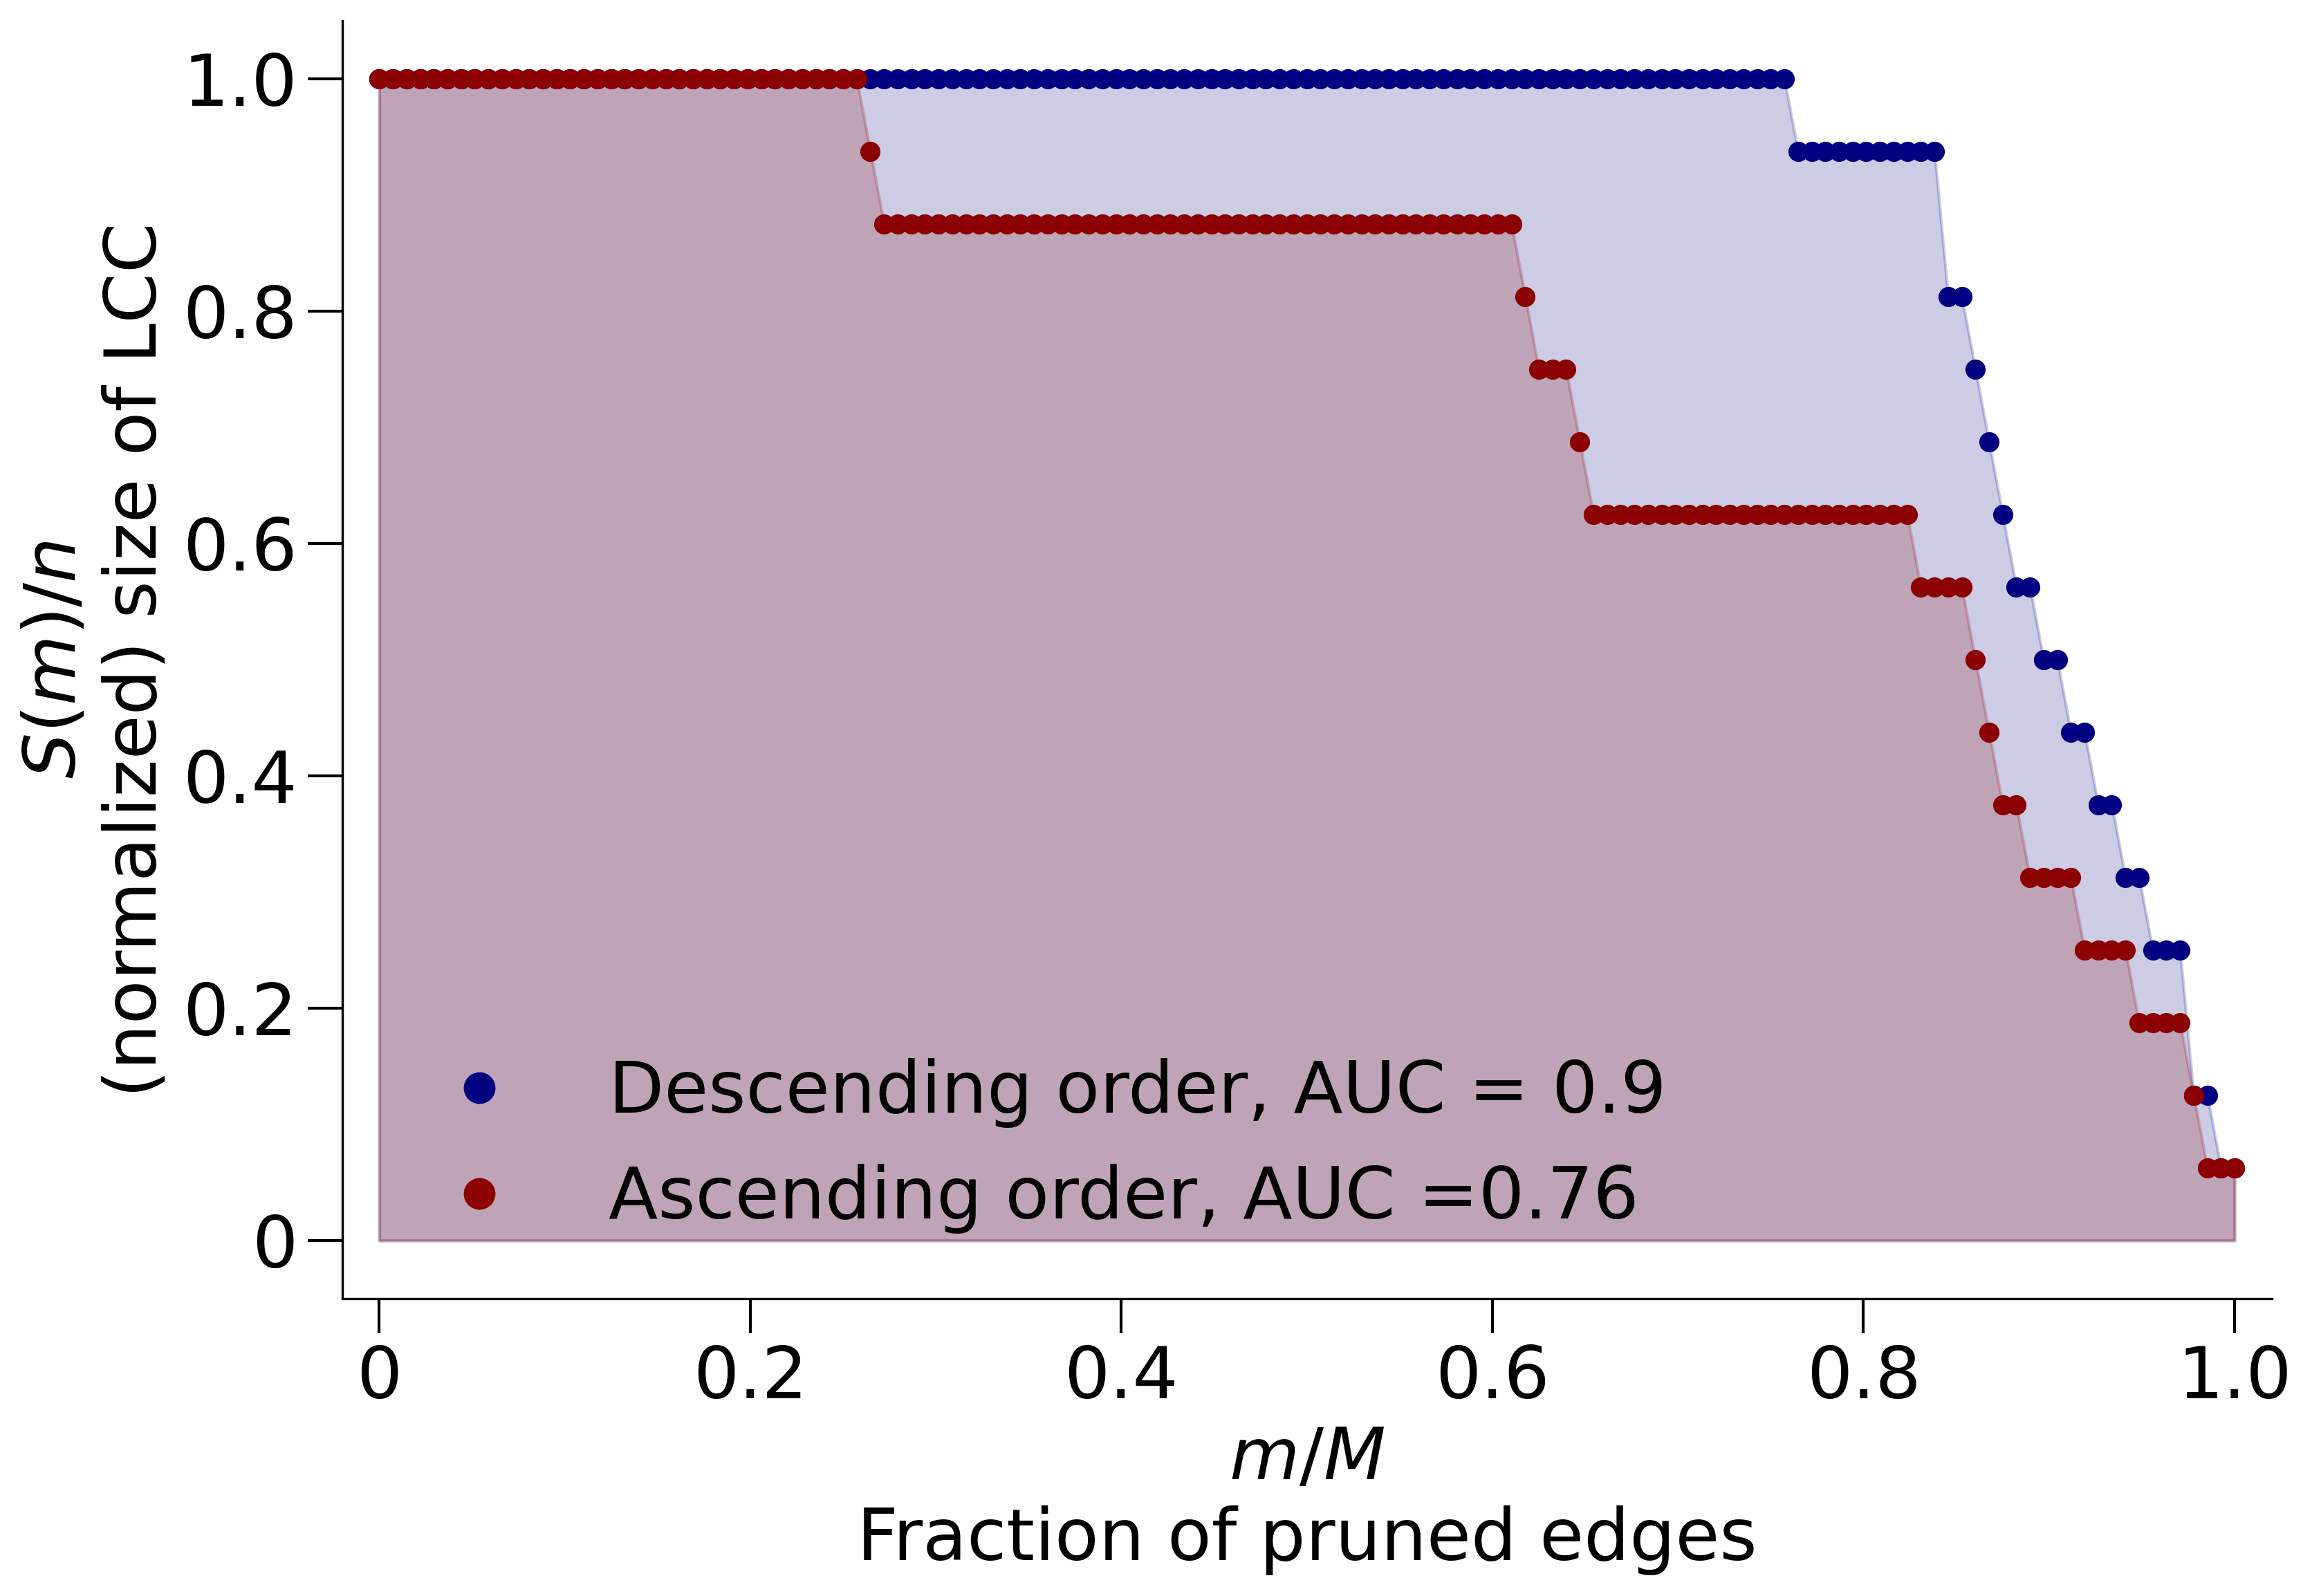

In [152]:

dic_colors_fn['total'] = 'tab:grey'
auc = lambda x,dx: dx * (x[1:-1].sum()) + dx/2 *(x[0] + x[-1])
for proj in ['plant', 'function']:

    # Initilize figure
    fig,ax = plt.subplots(figsize=(12,8), dpi=300)
    
    df = pd.DataFrame()
    if proj == 'function':
        A = np.matmul(P_matrix,P_matrix_t)  
    else:
        A = np.matmul(P_matrix_t,P_matrix)
   
    legend_elements = []
    for inc_dec in [1,0]: # wether to remove edges in increasing or decreasing order
        G = nx.from_numpy_array(A, parallel_edges=False, create_using=None)
        dic_edges = {(i,j):G[i][j]["weight"] for i,j in G.edges }
        Y0 = len(max(nx.connected_components(G), key=len))    
        edges = []
        weight = []
        for elem in dic_edges:
            edges.append(elem)
            weight.append(dic_edges[elem])

        if inc_dec==0:
            sort = np.argsort(np.array(weight))
        if inc_dec ==1:
            sort = np.argsort(np.array(weight))[::-1]
           
        weigth_sort = np.array(weight)[sort]
        edges_sort = list(np.array(edges)[sort])
        edges_sort = tuple(tuple(sub) for sub in edges_sort)
        nodes = [k for k in G.nodes]
        T = []
        T_2 = []
        T_2_2 = []
        x = []
        # remove edges in decreasing/ increasing order
        for edge in edges_sort:
            G.remove_edge(edge[0], edge[1])
            components = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
            T.append(len(components[0]))
            if len(components) >1:
                length = np.array([len(k) for k in components[1:]])
                areas = length **2
                T_2.append(np.mean(areas))
                T_2_2.append(len(components[1]))
            else:
                T_2.append(0)
                T_2_2.append(0)
            x.append(dic_edges[edge]+np.sum(x))
           
        if inc_dec==0:
            pc_asc = np.max(np.array(T_2))
            T_asc = T
            w_asc = weigth_sort
            color = 'darkred'
            marker = "v"
        if inc_dec==1:
            pc_des = np.max(np.array(T_2))
            T_des = T
            w_des = weigth_sort
            color = 'navy'
            marker = "^"
      
        y = np.array([Y0] + T) / max(T)
        x = np.arange(0,len(y),1)
        x = x / x.max()
        dx = x[2] - x[1]

        if inc_dec ==0:
            df['Edges counter (norm)'] = x
            df['Size largest comp (norm) (asc)'] = y
        if inc_dec == 1:
            df['Size largest comp (norm) (des)'] = y

        # Compute AUC
        Ax = auc(y, dx)
        area = scipy.integrate.simpson(y,dx=dx, even='avg')

        if inc_dec ==0 :
            label  = f'Ascending order, AUC ={round(area, 2)}'

        if inc_dec ==1 :
            label  = f'Descending order, AUC = {round(area, 2)}'
        
        ax.fill_between(x, y, y2=0, color = color, alpha = .2)
        ax.scatter(x, y, c = color)
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10, linestyle='none', markeredgecolor = color))
    
    # Plotting options
    fontsize = 25    
    ax.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)
    ax.set_xticks(np.arange(0,1.2,.2))
    ax.set_xlabel(r'$m/M$'+'\n'+'Fraction of pruned edges', fontsize= fontsize)
    ax.set_xticklabels(["0", '0.2', '0.4', '0.6', '0.8', '1.0'])
    ax.set_yticks(np.arange(0,1.2,.2))
    ax.set_ylabel(r'$S(m)/n$'+'\n'+'(normalized) size of LCC', fontsize= fontsize)
    ax.set_yticklabels(["0", '0.2', '0.4', '0.6', '0.8', '1.0'])
    for pos in [ 'top', 'right']:
        ax.spines[pos].set_visible(False)
    ax.set_xlim([0-.02,x[-1]+.02])
    ax.set_ylim([0-.05,x[-1]+.05])
    ax.legend(handles=legend_elements,fontsize= fontsize, frameon=False, loc = 'lower left')
    if saving:
        plt.savefig(plt_dir + f'/percolation_{proj}.pdf', bbox_inches='tight' ,  dpi=300)
        plt.savefig(plt_dir + f'/percolation_{proj}.png', bbox_inches='tight' ,  dpi=300)
        df.to_csv(df_dir+ f'/df_{proj}.csv',index=False)


# 7. Visualization of the metadata



The set {$f^\alpha_{ix}$} can be visualized in a 3-dimensional plot using $\alpha$, $i$ and $x$ as coordinates. The weight is color coded such that each point captures its participation strength in logscale. Ecological functions, plant species and animal/fungi species are sorted (in this order) such that larger average contribution appear first on the axis. 

In [153]:
"""sorting"""

func_to_cmp = myfun.func_cmap(functions, function_sorted,dic_colors_fn, cmp = 'Reds')
(species_array, 
species_axis, 
functions_array, 
functions_axis, 
animal_array, 
animal_axis, 
interaction_array) = \
    myfun.threedplot_sort_speces(head, separator, data_path, P_matrix_df)


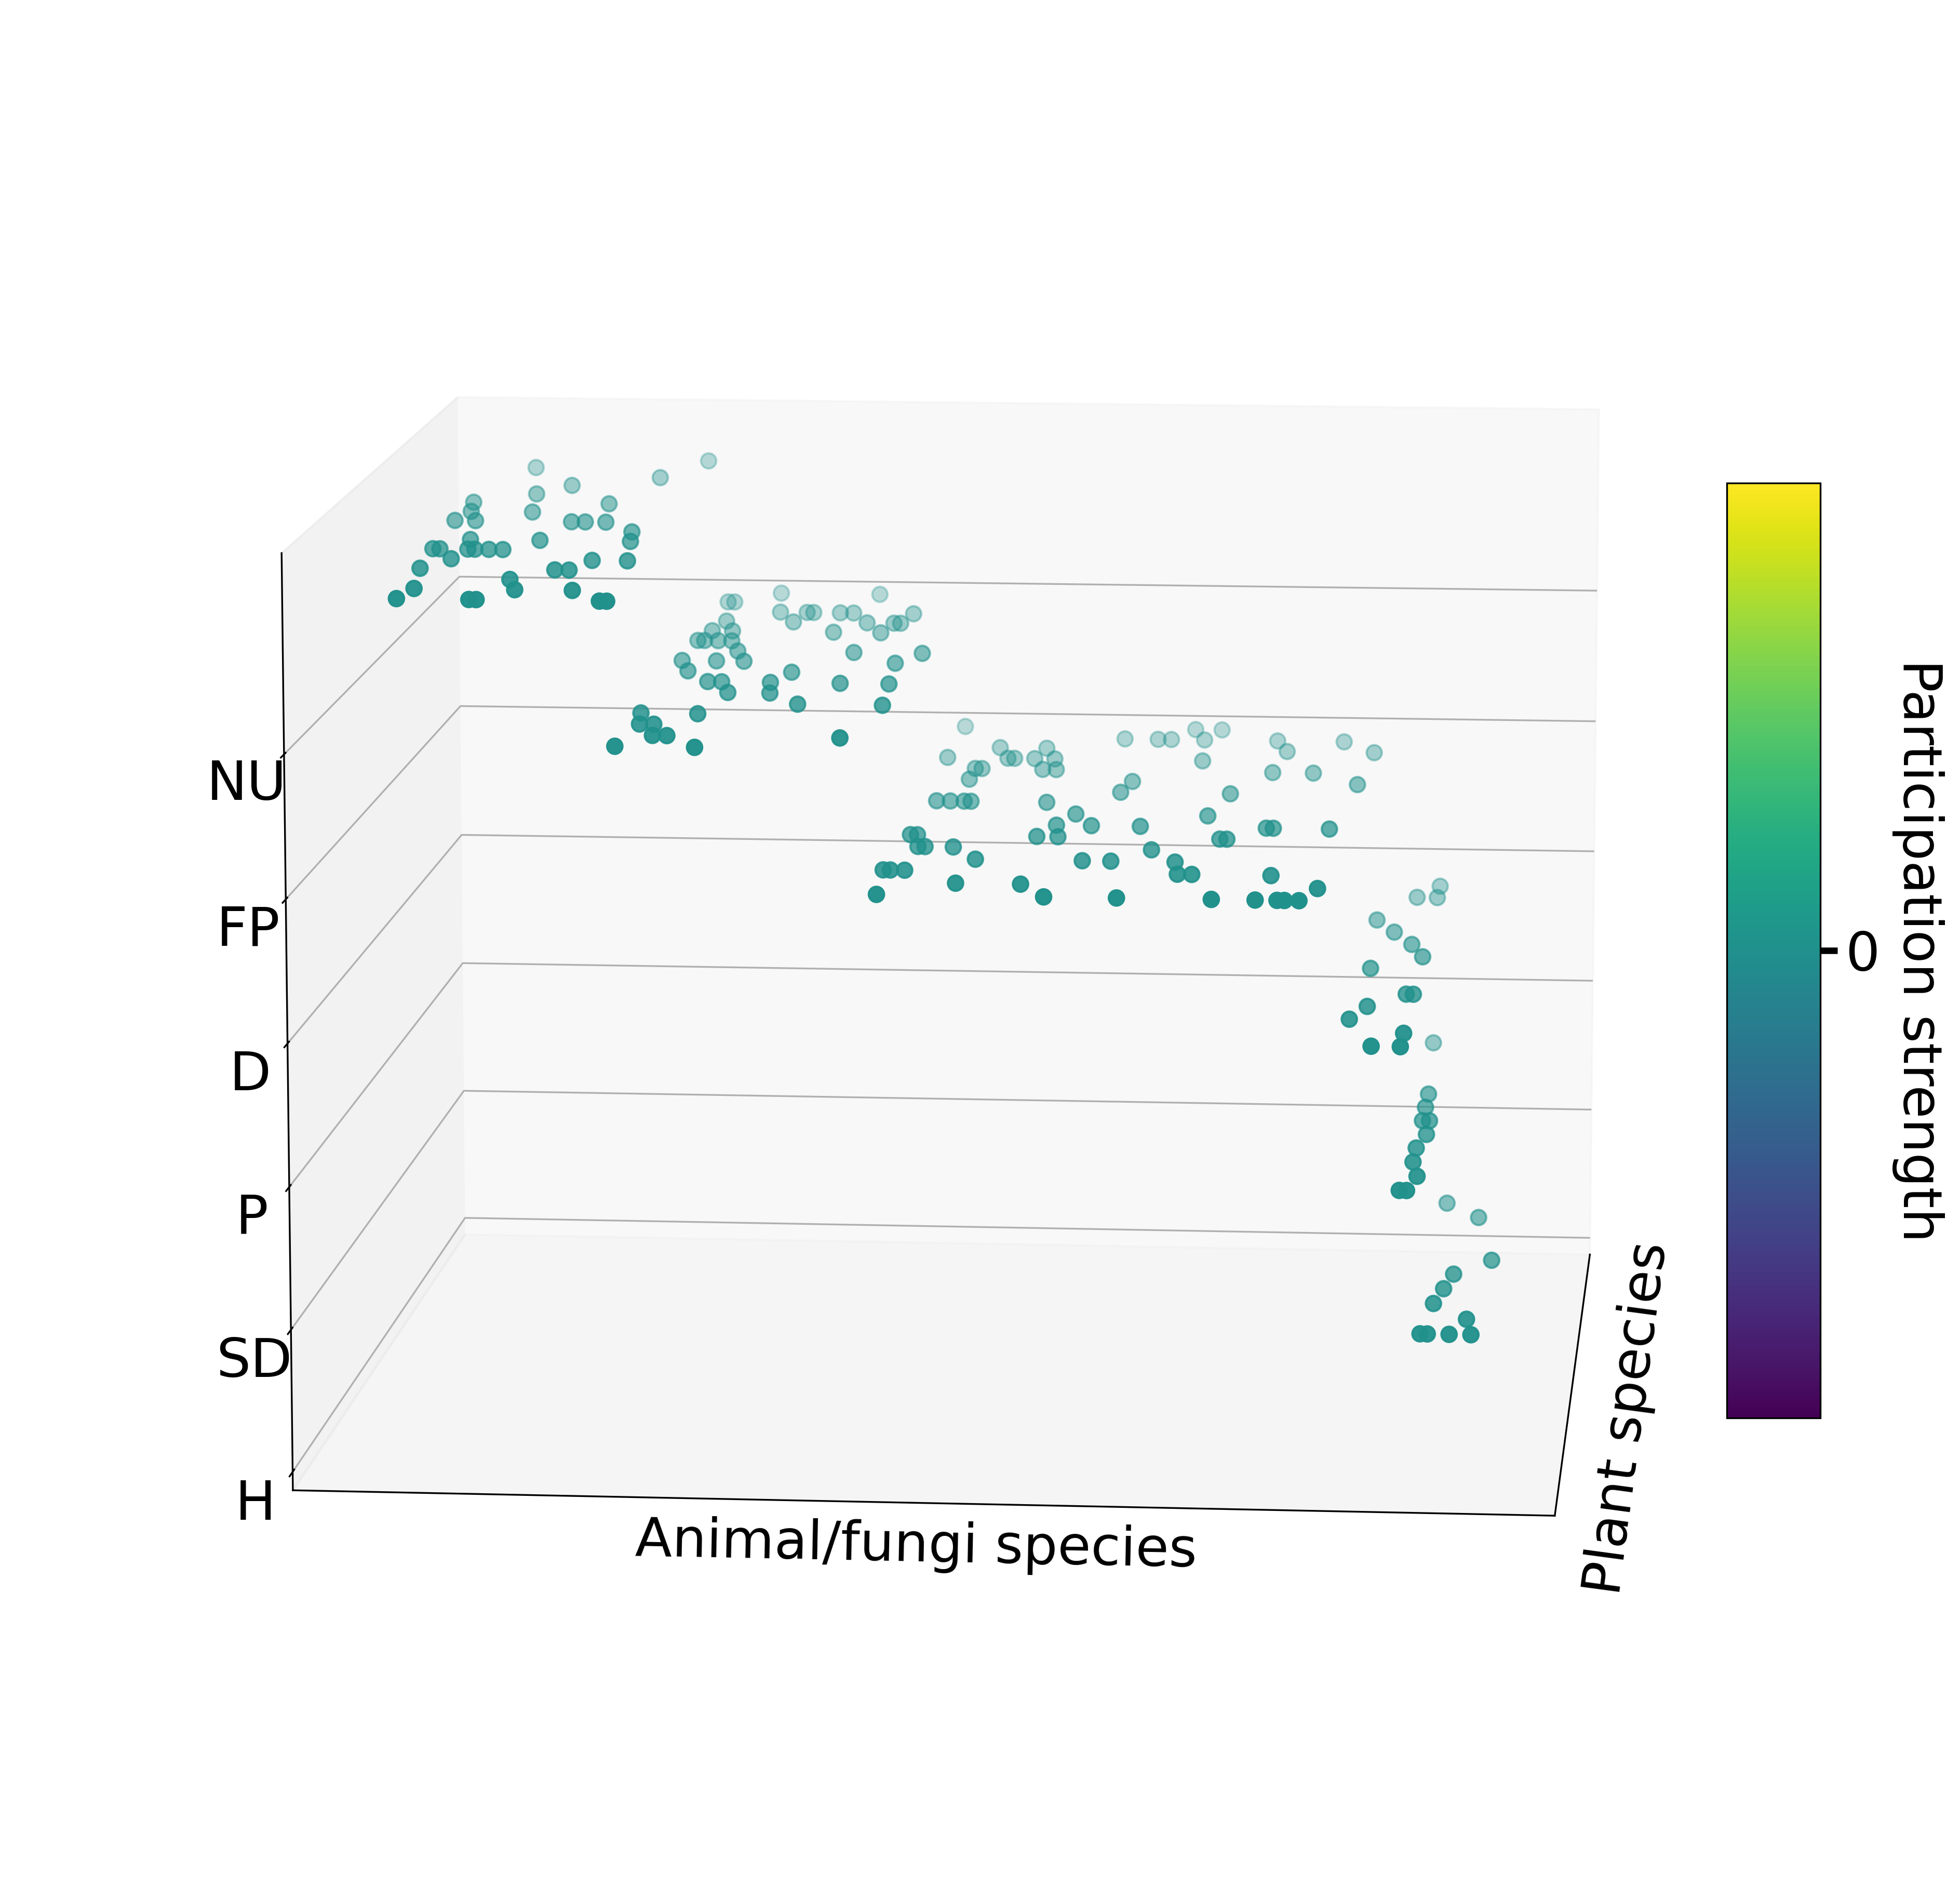

In [154]:
legend_elements = myfun.legend_cmap(functions_axis[::-1], dic_colors_fn, functions_axis, func_to_cmp)

x = species_array
y = animal_array
z = functions_array
c = np.log(np.array(interaction_array))

fig = plt.figure(figsize=(12,12), dpi=300)
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

labels_p = []
for i in P_matrix_df['plant_sp'].to_numpy():
    labels_p.append(dic_species[i])

sctt = ax.scatter3D(xs=x, ys=y, zs=z, c=c, cmap='viridis', s=50)
ax.set_xticks(np.arange(0,len(species_axis)),labelpad = -.5)
ax.set_xlabel('Plant species',labelpad = -.5,fontsize=fontsize)
ax.set_ylabel('Animal/fungi species',labelpad = -5,fontsize=fontsize)
ax.set_zticks(np.arange(0,len(functions_axis)), labelpad=1000)
ax.set_zticklabels( [dic_functions[i] for i in functions_axis],fontsize=fontsize)
ax.view_init(elev =10, azim=10)
ax.set_yticks([])
ax.set_yticklabels([], fontdict={'fontsize': 0})
ax.set_xticks([])
ax.set_xticklabels([], fontdict={'fontsize': 0})
ax.view_init(10, 5)
axins = inset_axes(ax,
                    width="5%",  
                    height="50%",
                    loc='right',
                    borderpad=3
                   )
cb = fig.colorbar(sctt, shrink = 0.8, aspect = 15, ticks = [-8,-6,-4,-2,0], cax=axins, orientation="vertical")
cb.ax.tick_params(labelsize=fontsize,width = 3, length = 8)
cb.set_label('Participation strength', labelpad=30,rotation=-90, fontsize = fontsize)

if saving:
    plt.savefig(plt_dir + '/3d_plot.pdf', bbox_inches='tight',  dpi=300 ) 
    plt.savefig(plt_dir + '/3d_plot.png', bbox_inches='tight',  dpi=300 ) 



Alternativelly, the 3-dimensional plot can be projected into the functions-animal/fungi 2-dimensional space, where darker colors within functions indicate larger interaction strength (logscale).

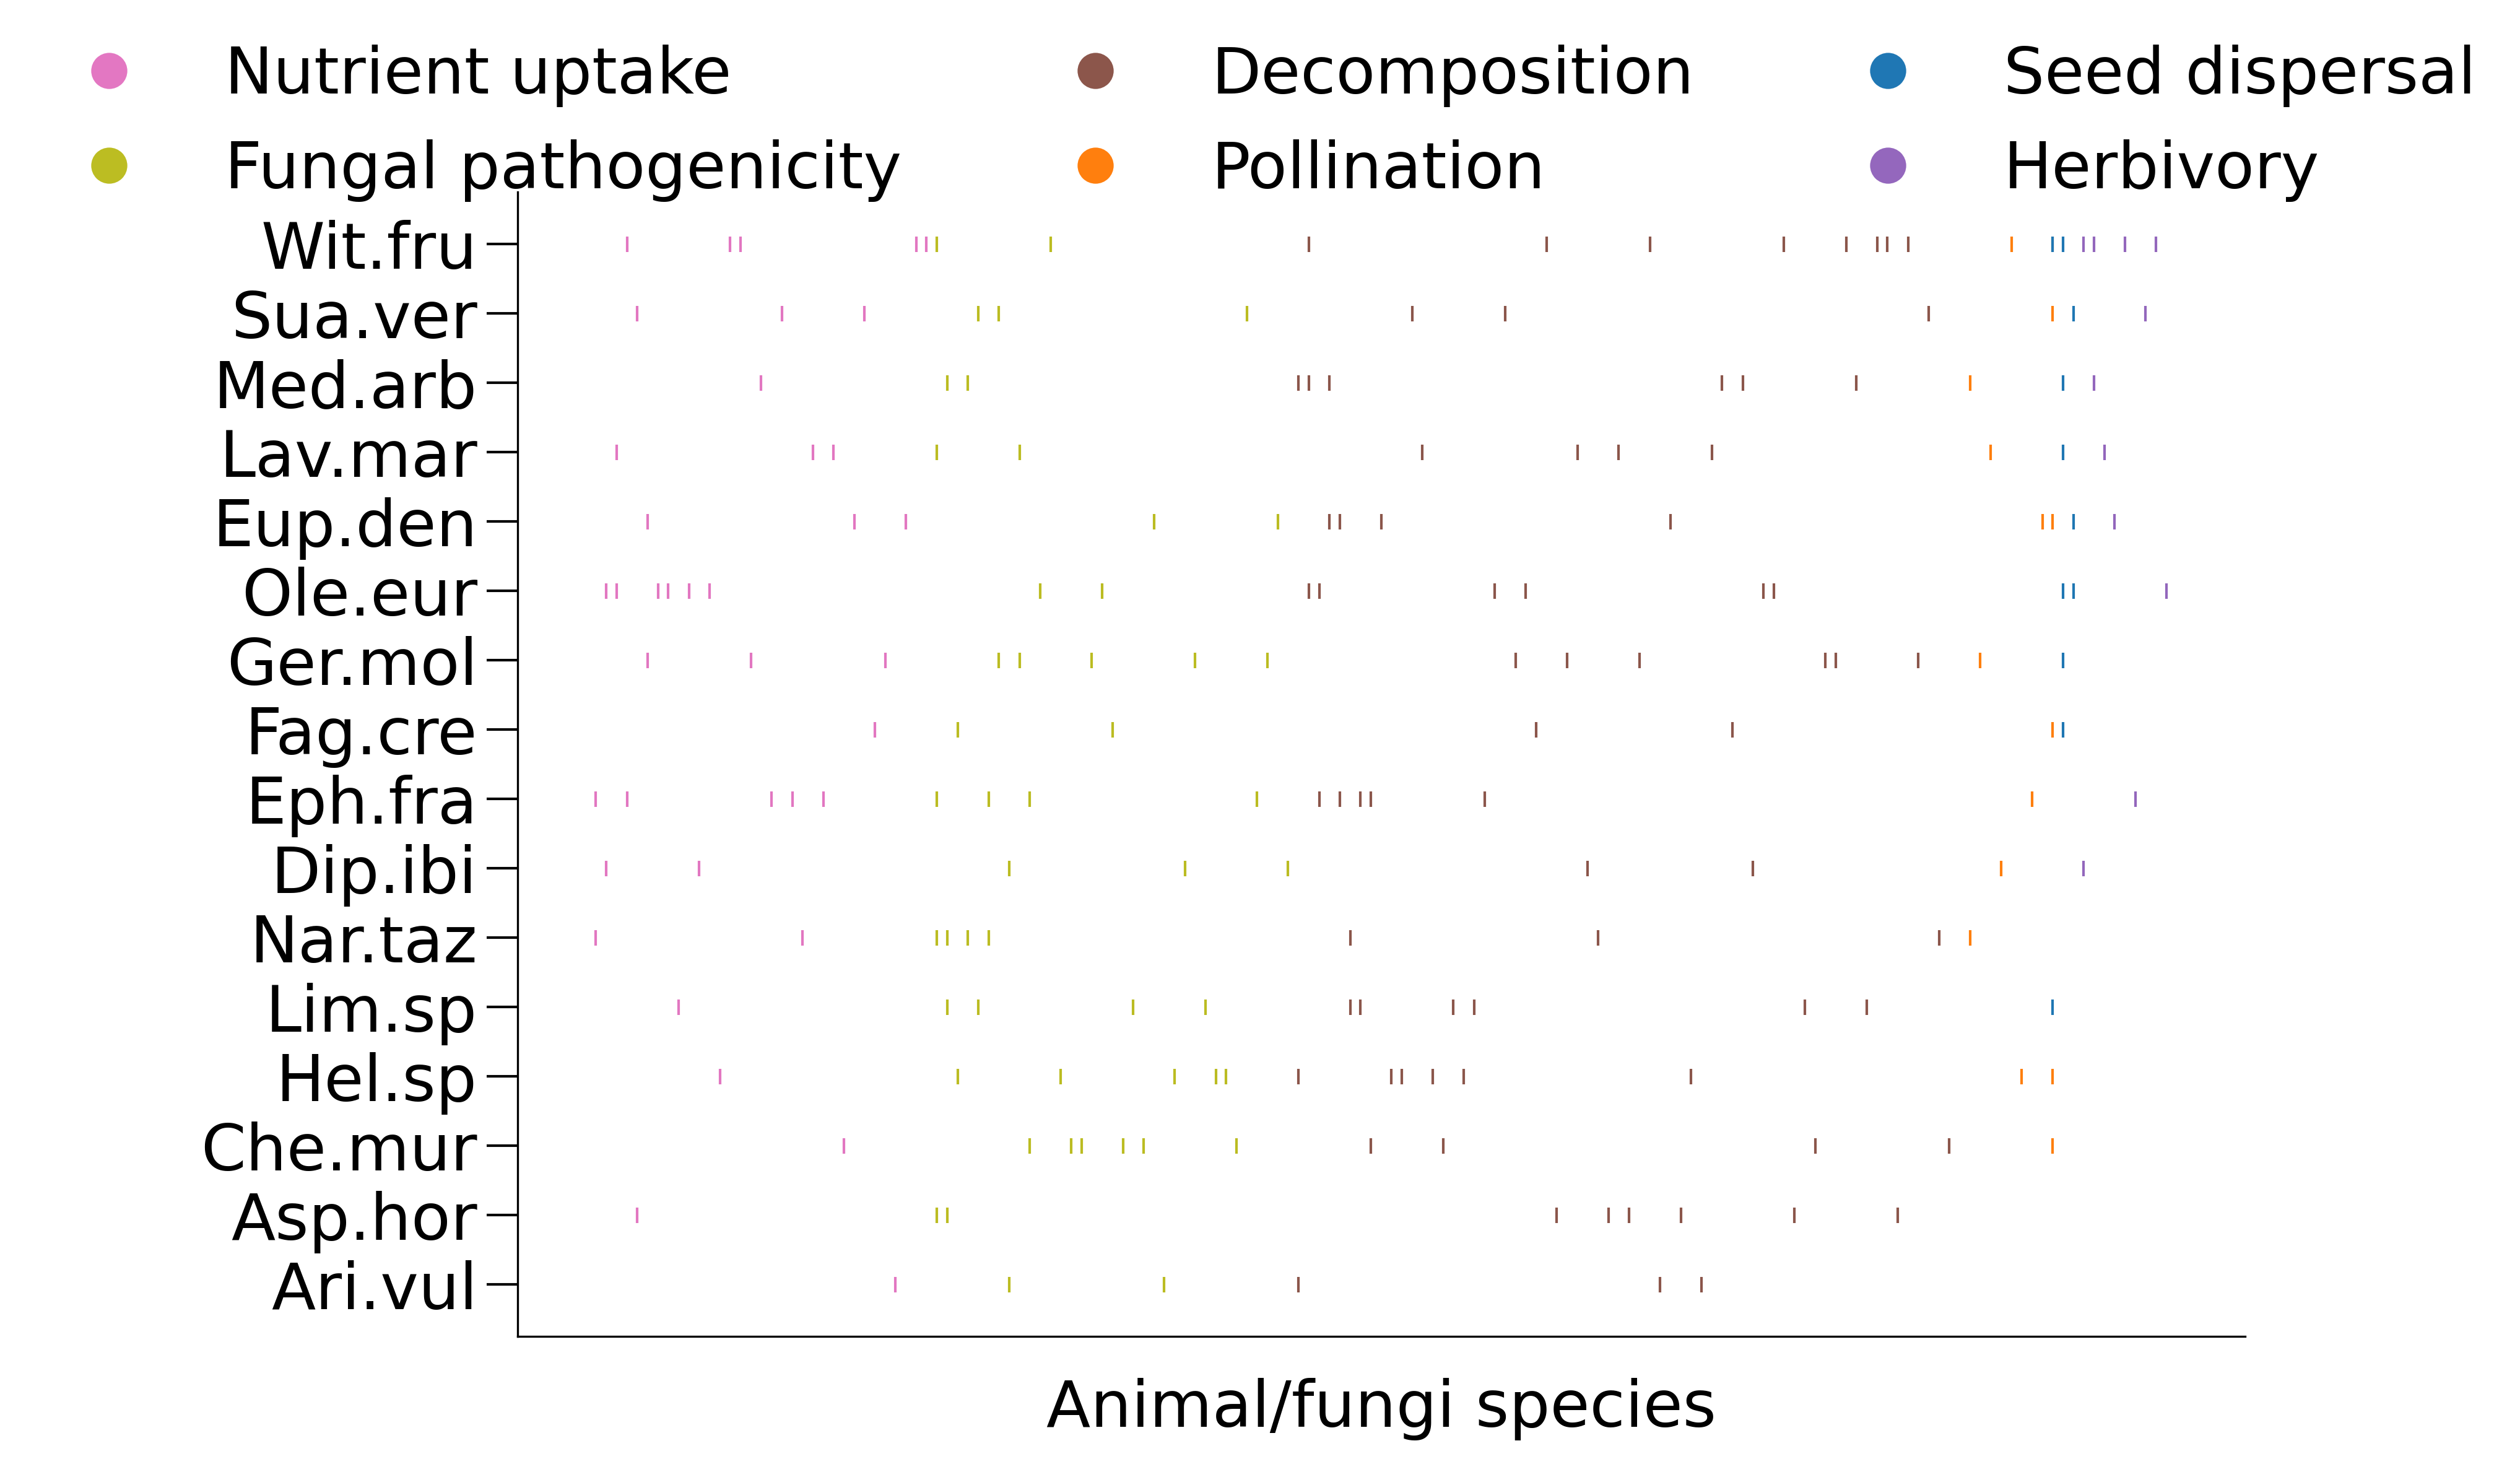

In [155]:
fig, ax = plt.subplots(figsize= (12,8), dpi=300)
x = np.array(x)
y = np.array(y)
z = np.array(z)
for i in range(1,len(functions_axis)+1)[::-1]:
    ax.scatter(y[z==i], x[z==i], c=c[z==i],  cmap=func_to_cmp[functions_axis[i-1]], vmin = c.min(), vmax = c.max(), label=functions_axis[i-1], marker='|',linewidths=1)

ax.legend(handles=legend_elements,loc='upper center', frameon=False, fontsize=fontsize,bbox_to_anchor=(0.43, 1.18), ncol=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_xlabel('Animal/fungi species', fontsize=fontsize)        
ax.set_yticks(np.arange(1,len_species+1,1))
ax.set_yticklabels(labels_p[::-1], minor=False, fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize, width=1, length=12)


# 8. HIERARCHICAL CLUSTERING

Interpreting the different participation strength as function features, $\Phi$ adopts the mathematical form of a correlation matrix (similarity-based matrix) that quantifies How similar functions are to each others. To visualize this, a hierarchical clustering of functions in the phytocentric embedding is performed. 

An analogous analysis is perfomred in $\Pi$, since its elements are based on how similar their participation strength across functions are and, hence, $\Pi$ adopts the form of a similarity matrix in a plant to plant similarity measure. 

In [156]:
P_matrix

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 1., 0.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.]])

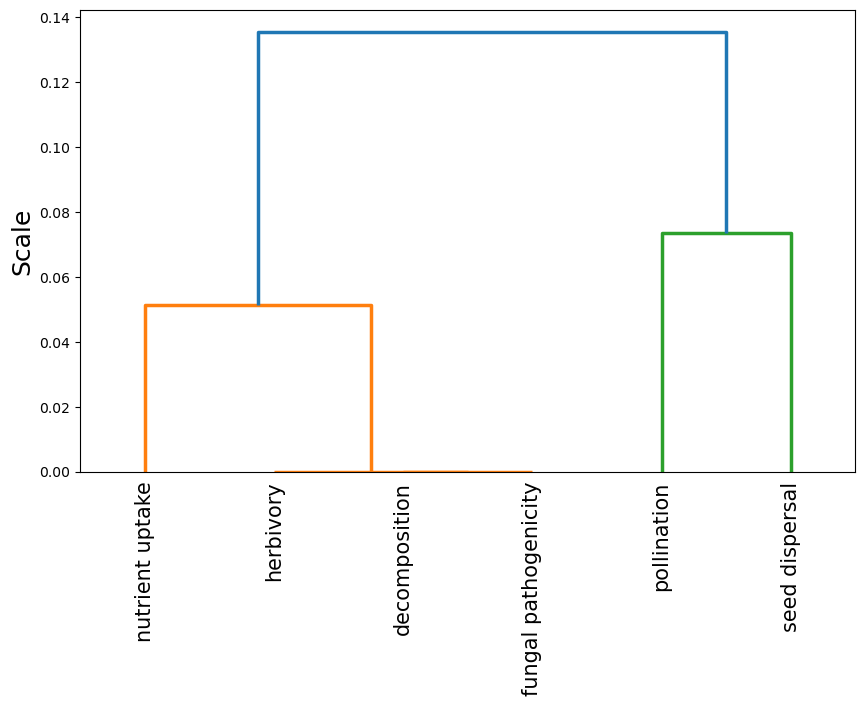

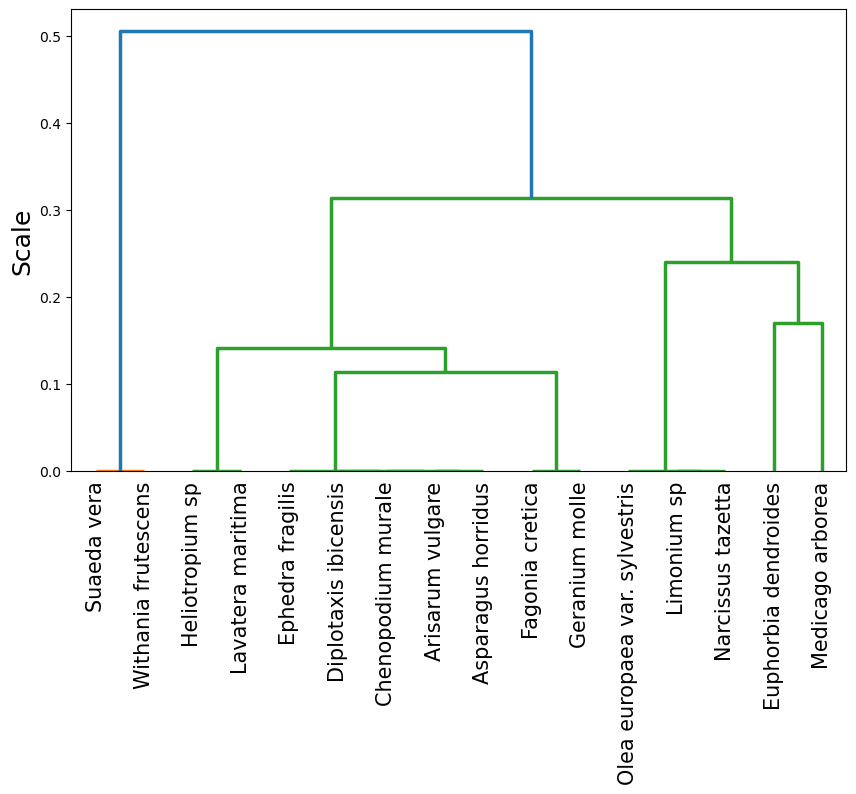

In [157]:
dissim_Phi = 1/P_t_times_P
dissim_Pi = 1/P_times_P_t


# Define the leaf names
leaf_names = functions

# Plot the dendrogram with annotated leaf names
myfun.plot_dendrogram_with_names(dissim_Phi, leaf_names)

# Define the leaf names
leaf_names = species

# Plot the dendrogram with annotated leaf names
myfun.plot_dendrogram_with_names(dissim_Pi, leaf_names)